# **Image Caption Generator**

In [ ]:
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [ ]:
BASE_DIR = '/content/drive/MyDrive/aml_project'
WORKING_DIR = '/content/drive/MyDrive/features'

In [ ]:
# load the model
model = InceptionV3()

# re-structure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
print(model.summary())

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


**Extract Image features**

In [ ]:
# Extract features from images
features = {}
directory = '/content/drive/MyDrive/aml_project/Images'

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)  # Use os.path.join for better compatibility
    image = load_img(img_path, target_size=(299, 299))  # Change target size to (299, 299)

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for VGG (or whichever model you are using)
    image = preprocess_input(image)

    # Extract features
    feature = model.predict(image, verbose=0)

    # Get image ID
    image_id = img_name.split('.')[0]

    # Store feature
    features[image_id] = feature


In [ ]:
# store features
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [ ]:
#load features from pickle
with open(os.path.join(WORKING_DIR,'features1.pkl'),'rb') as f:
  features=pickle.load(f)

**LOAD THE CAPTIONS DATA**

In [ ]:
with open(os.path.join(BASE_DIR,'captions.txt')) as f:
  next(f)
  captions_doc=f.read()

In [ ]:
mapping={}
for line in tqdm(captions_doc.split('\n')):
  tokens=line.split(',')
  if len(line)<2:
    continue
  image_id, caption=tokens[0],tokens[1:]
  image_id=image_id.split('.')[0]
  caption=" ".join(caption)
  if image_id not in mapping :
    mapping[image_id]=[]
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

**PREPROCESS TEXT DATA**

In [ ]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [ ]:
def clean(mapping):
  for key,captions in mapping.items():
    for i in range(len(captions)):
      caption=captions[i]
      caption=caption.lower()
      caption=caption.replace('[^A-Za-z]','')
      caption=caption.replace('\s+',' ')
      caption='startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i]=caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

**NEXT WE STORE THE PREPROCESS TEXT INTO THE LIST**

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

**NOW WE START PROCESS THE TEXT DATA**

In [ ]:
# TOKENIZING THE TEXT
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1


In [ ]:
vocab_size

8485

In [ ]:
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'shirt': 35,
 'down': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'front': 47,
 'sitting': 48,
 'holding': 49,
 'up': 50,
 'field': 51,
 'small': 52,
 'by': 53,
 'a': 54,
 'large': 55,
 'green': 56,
 'one': 57,
 'group': 58,
 'yellow': 59,
 'her': 60,
 'walking': 61,
 'children': 62,
 'men': 63,
 'into': 64,
 'air': 65,
 'beach': 66,
 'near': 67,
 'mouth': 68,
 'jumps': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'runs': 73,
 'its': 74,
 'from': 75,

In [ ]:
# get maximum length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

Train Test Split

In [ ]:
##After preprocessing the data now we will train, test and split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]



Now we will define a batch and include the padding sequence

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

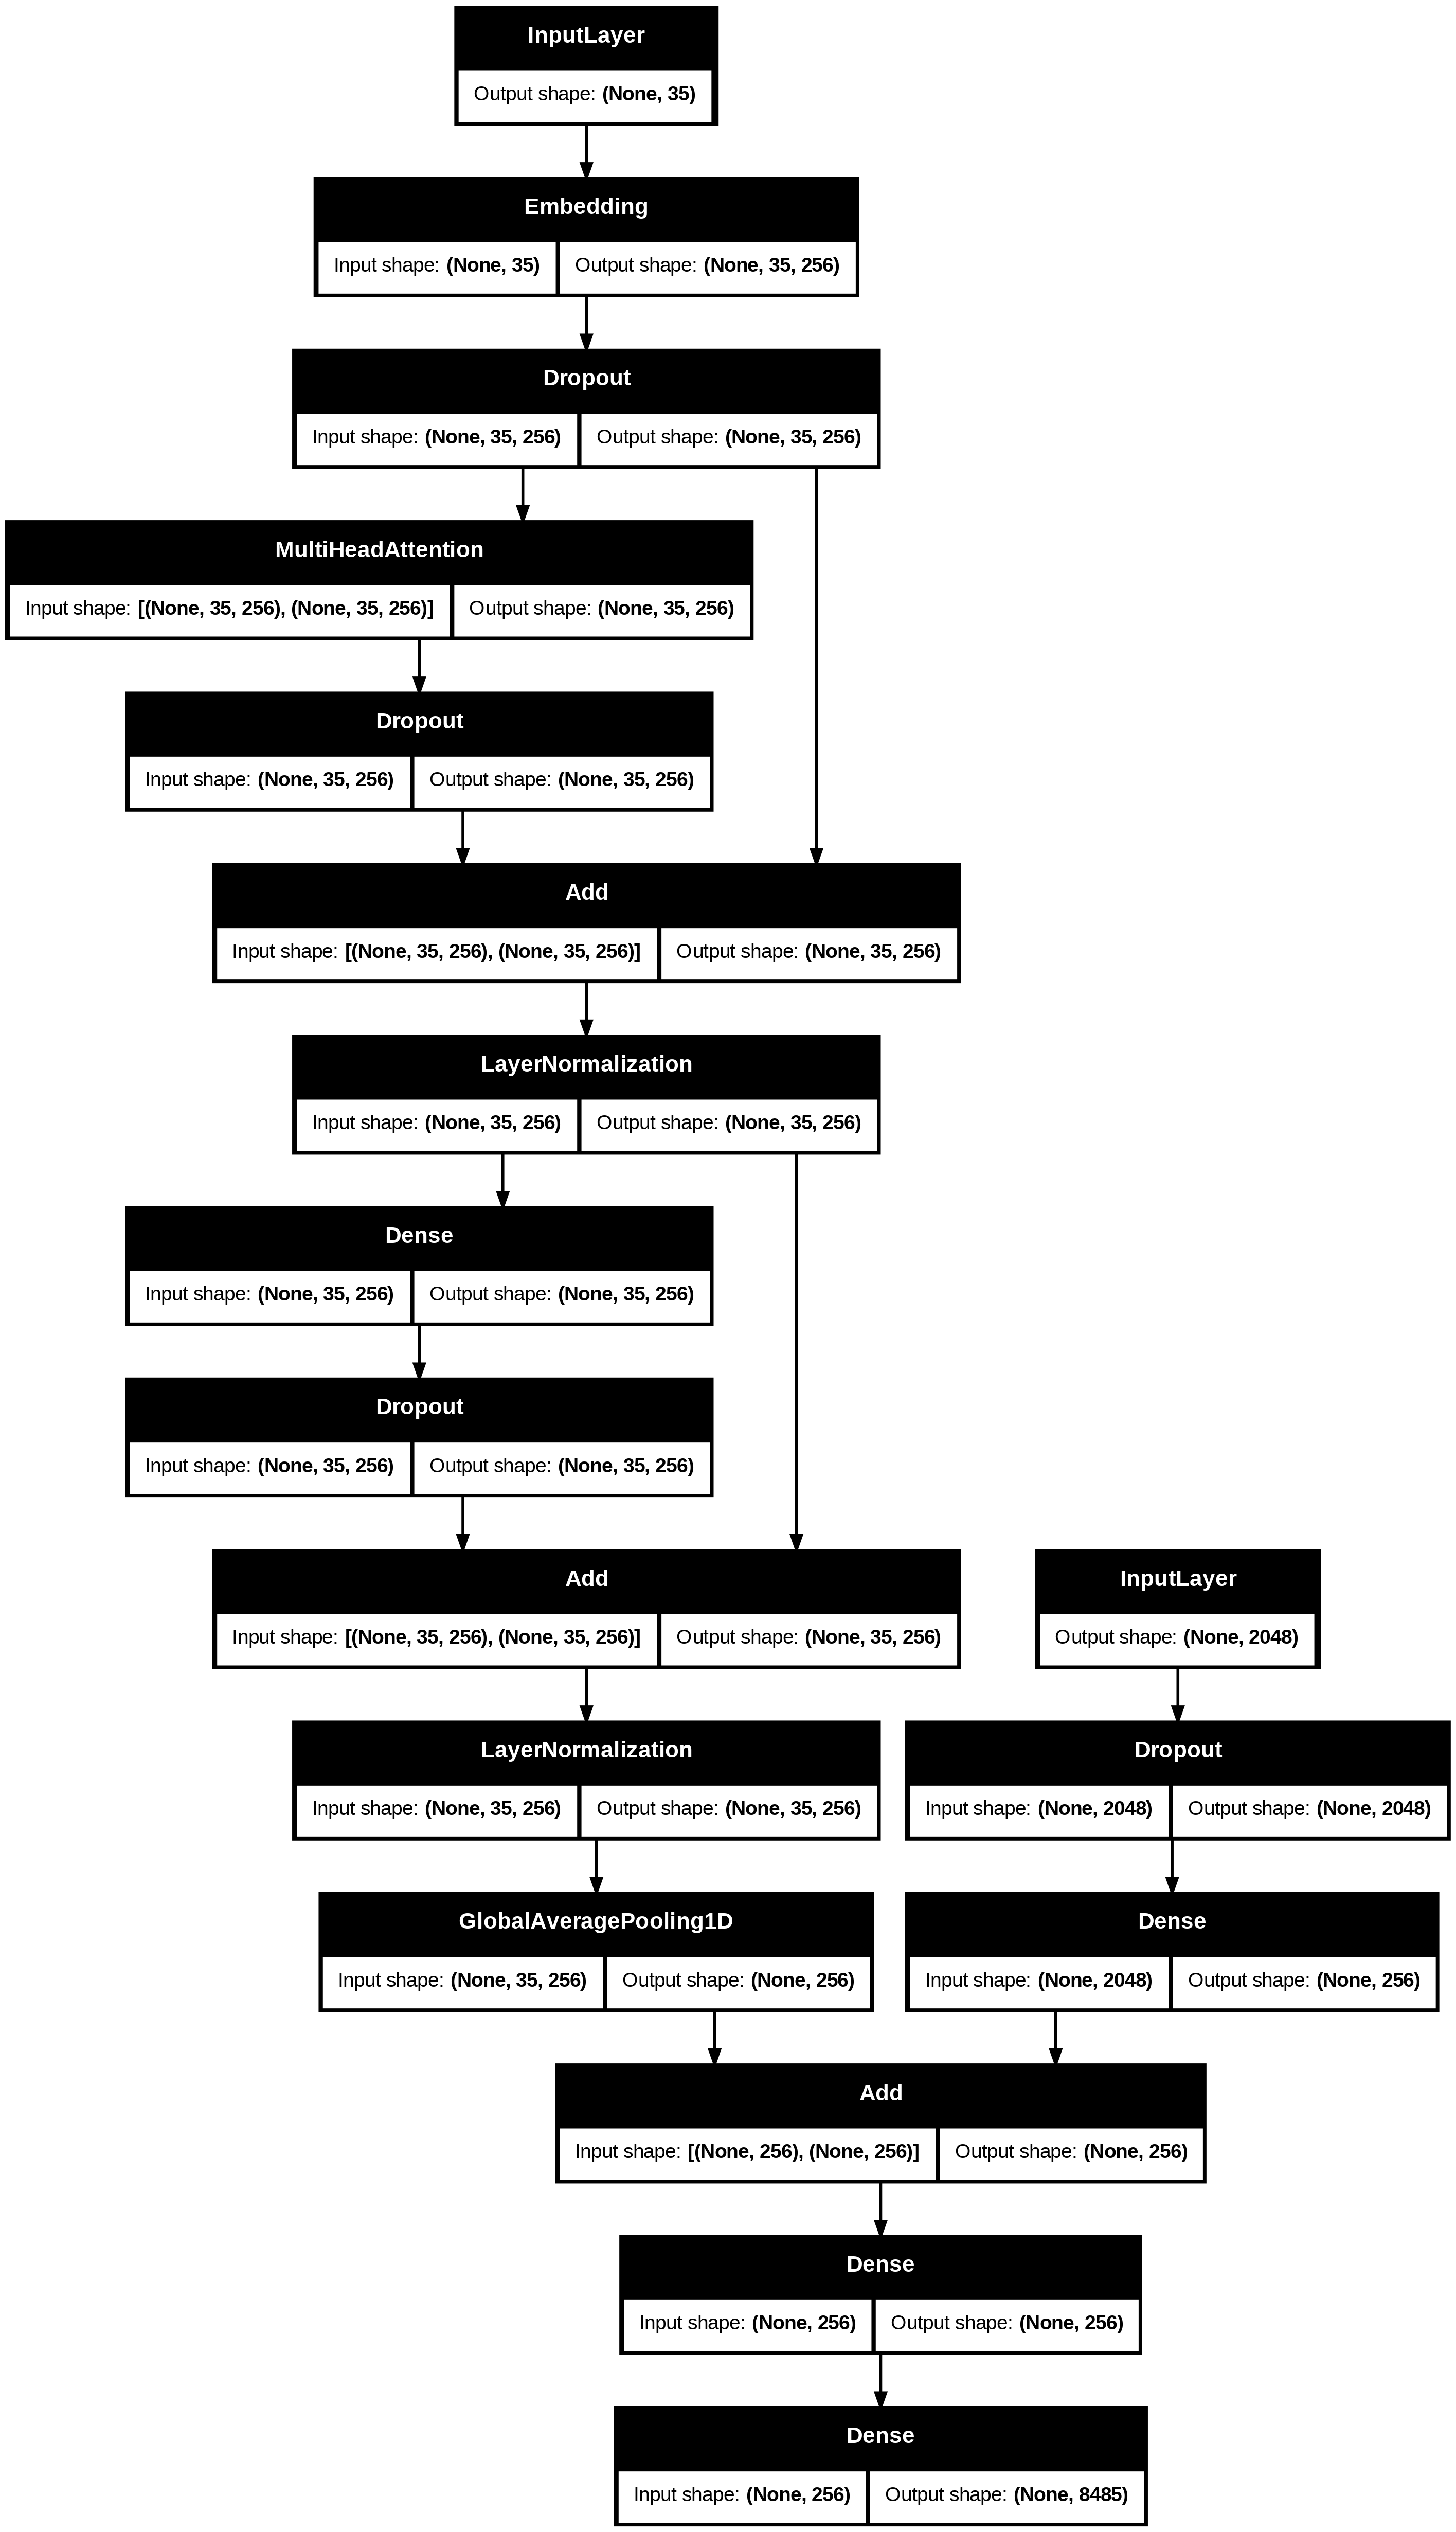

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Add
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# Encoder model

# Image feature layers
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers with transformer
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256)(inputs2)
se2 = Dropout(0.5)(se1)

# Transformer layer
# Multi-head attention block
attention_output = MultiHeadAttention(num_heads=8, key_dim=256)(se2, se2)
attention_output = Dropout(0.5)(attention_output)
attention_output = Add()([se2, attention_output])  # Residual connection
attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

# Feedforward layer
ffn_output = Dense(256, activation='relu')(attention_output)
ffn_output = Dropout(0.5)(ffn_output)
ffn_output = Add()([attention_output, ffn_output])  # Residual connection
ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

# Pool the outputs to get a fixed-size vector representation
se3 = GlobalAveragePooling1D()(ffn_output)

# Decoder model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)


Now let us train the model

In [ ]:
# Training parameters
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # Create data generator for the current epoch
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit the model for one epoch
    print(f"Epoch {i+1}/{epochs}")
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 1979s 9s/step - loss: 6.0841
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 85s 374ms/step - loss: 5.2988
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 83s 365ms/step - loss: 4.4936
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 371ms/step - loss: 4.1133
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 370ms/step - loss: 3.8823
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 370ms/step - loss: 3.7155
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 370ms/step - loss: 3.5796
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 368ms/step - loss: 3.4594
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 83s 366ms/step - loss: 3.3591
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 86s 379ms/step - loss: 3.2730
Epoch 11/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 369ms/step - loss: 3.2049
Epoch 12/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 84s 371ms/step - loss: 3.1514
Epoch 13/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 85s 373ms/step - loss: 3.0902
Epoch 14/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 91s 398ms/step - loss: 3.0406
Epoch 15/15
227/

You can save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model_trans.h5')

Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


Now we validate the data using BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store BLEU scores
bleu_1_scores = []
bleu_2_scores = []

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual captions for the image
    captions = mapping[key]
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # Append to the list for BLEU score calculation
    actual.append(actual_captions)
    predicted.append(y_pred)

    # Calculate BLEU-1 and BLEU-2 scores for the current prediction
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    # Store scores for visualization
    bleu_1_scores.append(bleu_1)
    bleu_2_scores.append(bleu_2)

    # Print BLEU scores for each image
    print("BLEU-1: %f" % bleu_1)
    print("BLEU-2: %f" % bleu_2)

  0%|          | 0/810 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

BLEU-1: 0.500000
BLEU-2: 0.000000


  0%|          | 2/810 [00:13<1:16:19,  5.67s/it]

BLEU-1: 0.521739
BLEU-2: 0.000000


  0%|          | 3/810 [00:14<46:12,  3.44s/it]  

BLEU-1: 0.542857
BLEU-2: 0.225594


  0%|          | 4/810 [00:15<33:49,  2.52s/it]

BLEU-1: 0.458333
BLEU-2: 0.176777


  1%|          | 5/810 [00:16<27:14,  2.03s/it]

BLEU-1: 0.409836
BLEU-2: 0.148174


  1%|          | 6/810 [00:17<21:21,  1.59s/it]

BLEU-1: 0.442857
BLEU-2: 0.186006


  1%|          | 7/810 [00:18<17:30,  1.31s/it]

BLEU-1: 0.435897
BLEU-2: 0.175206


  1%|          | 8/810 [00:18<14:56,  1.12s/it]

BLEU-1: 0.448276
BLEU-2: 0.199300


  1%|          | 9/810 [00:20<17:24,  1.30s/it]

BLEU-1: 0.429907
BLEU-2: 0.219670


  1%|          | 10/810 [00:21<15:09,  1.14s/it]

BLEU-1: 0.458333
BLEU-2: 0.266145


  1%|▏         | 11/810 [00:21<12:49,  1.04it/s]

BLEU-1: 0.472868
BLEU-2: 0.275934


  1%|▏         | 12/810 [00:22<10:54,  1.22it/s]

BLEU-1: 0.471014
BLEU-2: 0.266507


  2%|▏         | 13/810 [00:22<09:43,  1.36it/s]

BLEU-1: 0.489796
BLEU-2: 0.277054


  2%|▏         | 14/810 [00:23<09:19,  1.42it/s]

BLEU-1: 0.487342
BLEU-2: 0.266591


  2%|▏         | 15/810 [00:24<09:39,  1.37it/s]

BLEU-1: 0.476744
BLEU-2: 0.258466


  2%|▏         | 16/810 [00:25<10:34,  1.25it/s]

BLEU-1: 0.465608
BLEU-2: 0.254152


  2%|▏         | 17/810 [00:25<09:29,  1.39it/s]

BLEU-1: 0.484848
BLEU-2: 0.263907


  2%|▏         | 18/810 [00:27<12:34,  1.05it/s]

BLEU-1: 0.459821
BLEU-2: 0.250000


  2%|▏         | 19/810 [00:27<10:27,  1.26it/s]

BLEU-1: 0.456897
BLEU-2: 0.245075


  2%|▏         | 20/810 [00:28<10:30,  1.25it/s]

BLEU-1: 0.471545
BLEU-2: 0.274068


  3%|▎         | 21/810 [00:29<10:08,  1.30it/s]

BLEU-1: 0.472868
BLEU-2: 0.271704


  3%|▎         | 22/810 [00:29<09:05,  1.44it/s]

BLEU-1: 0.479401
BLEU-2: 0.279767


  3%|▎         | 23/810 [00:30<08:24,  1.56it/s]

BLEU-1: 0.492754
BLEU-2: 0.292739


  3%|▎         | 24/810 [00:30<07:47,  1.68it/s]

BLEU-1: 0.498233
BLEU-2: 0.294220


  3%|▎         | 25/810 [00:31<08:30,  1.54it/s]

BLEU-1: 0.513699
BLEU-2: 0.313245


  3%|▎         | 26/810 [00:32<09:14,  1.41it/s]

BLEU-1: 0.521595
BLEU-2: 0.320035


  3%|▎         | 27/810 [00:33<09:34,  1.36it/s]

BLEU-1: 0.517799
BLEU-2: 0.314886


  3%|▎         | 28/810 [00:35<16:30,  1.27s/it]

BLEU-1: 0.509375
BLEU-2: 0.306919


  4%|▎         | 29/810 [00:36<14:27,  1.11s/it]

BLEU-1: 0.521341
BLEU-2: 0.315256


  4%|▎         | 30/810 [00:36<12:31,  1.04it/s]

BLEU-1: 0.522124
BLEU-2: 0.315743


  4%|▍         | 31/810 [00:37<11:03,  1.17it/s]

BLEU-1: 0.530086
BLEU-2: 0.321481


  4%|▍         | 32/810 [00:37<09:29,  1.37it/s]

BLEU-1: 0.529412
BLEU-2: 0.317798


  4%|▍         | 33/810 [00:38<08:54,  1.45it/s]

BLEU-1: 0.535519
BLEU-2: 0.315763


  4%|▍         | 34/810 [00:38<07:43,  1.67it/s]

BLEU-1: 0.533512
BLEU-2: 0.312369


  4%|▍         | 35/810 [00:39<07:23,  1.75it/s]

BLEU-1: 0.544503
BLEU-2: 0.331424


  4%|▍         | 36/810 [00:40<07:38,  1.69it/s]

BLEU-1: 0.544529
BLEU-2: 0.326757


  5%|▍         | 37/810 [00:40<08:35,  1.50it/s]

BLEU-1: 0.549261
BLEU-2: 0.329638


  5%|▍         | 38/810 [00:41<09:17,  1.39it/s]

BLEU-1: 0.557143
BLEU-2: 0.341583


  5%|▍         | 39/810 [00:42<08:13,  1.56it/s]

BLEU-1: 0.563084
BLEU-2: 0.348700


  5%|▍         | 40/810 [00:42<07:50,  1.64it/s]

BLEU-1: 0.567506
BLEU-2: 0.352655


  5%|▌         | 41/810 [00:43<07:35,  1.69it/s]

BLEU-1: 0.576233
BLEU-2: 0.365709


  5%|▌         | 42/810 [00:43<07:21,  1.74it/s]

BLEU-1: 0.578022
BLEU-2: 0.364636


  5%|▌         | 43/810 [00:44<07:03,  1.81it/s]

BLEU-1: 0.575431
BLEU-2: 0.362236


  5%|▌         | 44/810 [00:44<06:59,  1.83it/s]

BLEU-1: 0.581395
BLEU-2: 0.369971


  6%|▌         | 45/810 [00:45<06:53,  1.85it/s]

BLEU-1: 0.580913
BLEU-2: 0.371819


  6%|▌         | 46/810 [00:46<07:16,  1.75it/s]

BLEU-1: 0.576065
BLEU-2: 0.366099


  6%|▌         | 47/810 [00:46<08:00,  1.59it/s]

BLEU-1: 0.577689
BLEU-2: 0.366855


  6%|▌         | 48/810 [00:47<08:06,  1.57it/s]

BLEU-1: 0.576471
BLEU-2: 0.367096


  6%|▌         | 49/810 [00:48<08:47,  1.44it/s]

BLEU-1: 0.572254
BLEU-2: 0.362625


  6%|▌         | 50/810 [00:49<10:36,  1.19it/s]

BLEU-1: 0.579245
BLEU-2: 0.365992


  6%|▋         | 51/810 [00:50<12:06,  1.05it/s]

BLEU-1: 0.583794
BLEU-2: 0.371002


  6%|▋         | 52/810 [00:51<11:59,  1.05it/s]

BLEU-1: 0.581227
BLEU-2: 0.366480


  7%|▋         | 53/810 [00:53<15:51,  1.26s/it]

BLEU-1: 0.569948
BLEU-2: 0.359086


  7%|▋         | 54/810 [00:54<14:20,  1.14s/it]

BLEU-1: 0.569257
BLEU-2: 0.356331


  7%|▋         | 55/810 [00:55<11:52,  1.06it/s]

BLEU-1: 0.570000
BLEU-2: 0.355739


  7%|▋         | 56/810 [00:55<10:14,  1.23it/s]

BLEU-1: 0.571429
BLEU-2: 0.356509


  7%|▋         | 57/810 [00:56<09:10,  1.37it/s]

BLEU-1: 0.571197
BLEU-2: 0.353887


  7%|▋         | 58/810 [00:57<10:05,  1.24it/s]

BLEU-1: 0.569401
BLEU-2: 0.354323


  7%|▋         | 59/810 [00:57<09:40,  1.29it/s]

BLEU-1: 0.572755
BLEU-2: 0.356154


  7%|▋         | 60/810 [00:58<08:31,  1.47it/s]

BLEU-1: 0.570336
BLEU-2: 0.353300


  8%|▊         | 61/810 [00:58<07:54,  1.58it/s]

BLEU-1: 0.576169
BLEU-2: 0.360783


  8%|▊         | 62/810 [00:59<07:30,  1.66it/s]

BLEU-1: 0.577381
BLEU-2: 0.362722


  8%|▊         | 63/810 [00:59<07:09,  1.74it/s]

BLEU-1: 0.578561
BLEU-2: 0.362030


  8%|▊         | 64/810 [01:00<06:48,  1.82it/s]

BLEU-1: 0.577649
BLEU-2: 0.360995


  8%|▊         | 65/810 [01:00<07:10,  1.73it/s]

BLEU-1: 0.577143
BLEU-2: 0.357985


  8%|▊         | 66/810 [01:01<07:10,  1.73it/s]

BLEU-1: 0.576056
BLEU-2: 0.355140


  8%|▊         | 67/810 [01:02<07:00,  1.77it/s]

BLEU-1: 0.571627
BLEU-2: 0.351595


  8%|▊         | 68/810 [01:02<06:38,  1.86it/s]

BLEU-1: 0.569464
BLEU-2: 0.349060


  9%|▊         | 69/810 [01:03<06:54,  1.79it/s]

BLEU-1: 0.573370
BLEU-2: 0.355478


  9%|▊         | 70/810 [01:04<08:43,  1.41it/s]

BLEU-1: 0.570856
BLEU-2: 0.354194


  9%|▉         | 71/810 [01:04<08:34,  1.44it/s]

BLEU-1: 0.571429
BLEU-2: 0.352557


  9%|▉         | 72/810 [01:06<11:48,  1.04it/s]

BLEU-1: 0.568831
BLEU-2: 0.349631


  9%|▉         | 73/810 [01:07<10:55,  1.12it/s]

BLEU-1: 0.570694
BLEU-2: 0.350775


  9%|▉         | 74/810 [01:08<11:39,  1.05it/s]

BLEU-1: 0.570164
BLEU-2: 0.351080


  9%|▉         | 75/810 [01:10<17:41,  1.44s/it]

BLEU-1: 0.552600
BLEU-2: 0.341818


  9%|▉         | 76/810 [01:11<15:23,  1.26s/it]

BLEU-1: 0.552381
BLEU-2: 0.342240


 10%|▉         | 77/810 [01:12<13:24,  1.10s/it]

BLEU-1: 0.551643
BLEU-2: 0.340622


 10%|▉         | 78/810 [01:13<12:36,  1.03s/it]

BLEU-1: 0.548499
BLEU-2: 0.337868


 10%|▉         | 79/810 [01:13<10:51,  1.12it/s]

BLEU-1: 0.549714
BLEU-2: 0.338584


 10%|▉         | 80/810 [01:14<09:32,  1.27it/s]

BLEU-1: 0.552036
BLEU-2: 0.339633


 10%|█         | 81/810 [01:14<08:36,  1.41it/s]

BLEU-1: 0.554311
BLEU-2: 0.341662


 10%|█         | 82/810 [01:15<07:42,  1.57it/s]

BLEU-1: 0.553829
BLEU-2: 0.341044


 10%|█         | 83/810 [01:15<07:46,  1.56it/s]

BLEU-1: 0.554336
BLEU-2: 0.339340


 10%|█         | 84/810 [01:16<07:47,  1.55it/s]

BLEU-1: 0.555315
BLEU-2: 0.338587


 10%|█         | 85/810 [01:17<07:08,  1.69it/s]

BLEU-1: 0.554839
BLEU-2: 0.338010


 11%|█         | 86/810 [01:17<07:33,  1.60it/s]

BLEU-1: 0.555202
BLEU-2: 0.336905


 11%|█         | 87/810 [01:18<07:29,  1.61it/s]

BLEU-1: 0.557773
BLEU-2: 0.339740


 11%|█         | 88/810 [01:19<08:19,  1.44it/s]

BLEU-1: 0.560041
BLEU-2: 0.341655


 11%|█         | 89/810 [01:20<09:01,  1.33it/s]

BLEU-1: 0.562500
BLEU-2: 0.343444


 11%|█         | 90/810 [01:21<09:21,  1.28it/s]

BLEU-1: 0.563452
BLEU-2: 0.343113


 11%|█         | 91/810 [01:21<09:47,  1.22it/s]

BLEU-1: 0.560804
BLEU-2: 0.340598


 11%|█▏        | 92/810 [01:22<10:16,  1.16it/s]

BLEU-1: 0.562189
BLEU-2: 0.341143


 11%|█▏        | 93/810 [01:23<10:21,  1.15it/s]

BLEU-1: 0.564229
BLEU-2: 0.342442


 12%|█▏        | 94/810 [01:24<11:22,  1.05it/s]

BLEU-1: 0.563173
BLEU-2: 0.341532


 12%|█▏        | 95/810 [01:25<11:24,  1.05it/s]

BLEU-1: 0.561896
BLEU-2: 0.338958


 12%|█▏        | 96/810 [01:26<09:51,  1.21it/s]

BLEU-1: 0.562800
BLEU-2: 0.340423


 12%|█▏        | 97/810 [01:27<08:59,  1.32it/s]

BLEU-1: 0.563688
BLEU-2: 0.341862


 12%|█▏        | 98/810 [01:29<14:04,  1.19s/it]

BLEU-1: 0.549632
BLEU-2: 0.332388


 12%|█▏        | 99/810 [01:29<11:45,  1.01it/s]

BLEU-1: 0.548769
BLEU-2: 0.331623


 12%|█▏        | 100/810 [01:30<10:09,  1.17it/s]

BLEU-1: 0.552441
BLEU-2: 0.337155


 12%|█▏        | 101/810 [01:30<08:48,  1.34it/s]

BLEU-1: 0.552065
BLEU-2: 0.335873


 13%|█▎        | 102/810 [01:31<08:07,  1.45it/s]

BLEU-1: 0.552093
BLEU-2: 0.336176


 13%|█▎        | 103/810 [01:31<07:21,  1.60it/s]

BLEU-1: 0.550840
BLEU-2: 0.334649


 13%|█▎        | 104/810 [01:32<06:23,  1.84it/s]

BLEU-1: 0.553210
BLEU-2: 0.337742


 13%|█▎        | 105/810 [01:32<07:16,  1.61it/s]

BLEU-1: 0.553043
BLEU-2: 0.337319


 13%|█▎        | 106/810 [01:33<07:10,  1.63it/s]

BLEU-1: 0.552586
BLEU-2: 0.337295


 13%|█▎        | 107/810 [01:34<06:41,  1.75it/s]

BLEU-1: 0.553082
BLEU-2: 0.337105


 13%|█▎        | 108/810 [01:34<06:35,  1.78it/s]

BLEU-1: 0.553101
BLEU-2: 0.336617


 13%|█▎        | 109/810 [01:35<06:32,  1.79it/s]

BLEU-1: 0.554806
BLEU-2: 0.338173


 14%|█▎        | 110/810 [01:35<06:37,  1.76it/s]

BLEU-1: 0.557789
BLEU-2: 0.341016


 14%|█▎        | 111/810 [01:36<07:13,  1.61it/s]

BLEU-1: 0.560732
BLEU-2: 0.344565


 14%|█▍        | 112/810 [01:37<07:32,  1.54it/s]

BLEU-1: 0.561983
BLEU-2: 0.343848


 14%|█▍        | 113/810 [01:38<09:46,  1.19it/s]

BLEU-1: 0.561733
BLEU-2: 0.342648


 14%|█▍        | 114/810 [01:39<11:05,  1.05it/s]

BLEU-1: 0.561489
BLEU-2: 0.342932


 14%|█▍        | 115/810 [01:42<17:23,  1.50s/it]

BLEU-1: 0.550314
BLEU-2: 0.335039


 14%|█▍        | 116/810 [01:43<14:55,  1.29s/it]

BLEU-1: 0.549065
BLEU-2: 0.333079


 14%|█▍        | 117/810 [01:43<12:32,  1.09s/it]

BLEU-1: 0.547913
BLEU-2: 0.331454


 15%|█▍        | 118/810 [01:44<10:24,  1.11it/s]

BLEU-1: 0.546083
BLEU-2: 0.329921


 15%|█▍        | 119/810 [01:45<10:28,  1.10it/s]

BLEU-1: 0.544833
BLEU-2: 0.328442


 15%|█▍        | 120/810 [01:46<10:20,  1.11it/s]

BLEU-1: 0.542857
BLEU-2: 0.326080


 15%|█▍        | 121/810 [01:47<10:33,  1.09it/s]

BLEU-1: 0.542348
BLEU-2: 0.325969


 15%|█▌        | 122/810 [01:47<10:02,  1.14it/s]

BLEU-1: 0.542311
BLEU-2: 0.325722


 15%|█▌        | 123/810 [01:48<09:49,  1.17it/s]

BLEU-1: 0.543732
BLEU-2: 0.326583


 15%|█▌        | 124/810 [01:49<08:31,  1.34it/s]

BLEU-1: 0.542029
BLEU-2: 0.325162


 15%|█▌        | 125/810 [01:49<07:50,  1.46it/s]

BLEU-1: 0.542837
BLEU-2: 0.325694


 16%|█▌        | 126/810 [01:50<07:23,  1.54it/s]

BLEU-1: 0.542918
BLEU-2: 0.326004


 16%|█▌        | 127/810 [01:50<06:50,  1.66it/s]

BLEU-1: 0.541252
BLEU-2: 0.324612


 16%|█▌        | 128/810 [01:51<06:45,  1.68it/s]

BLEU-1: 0.542433
BLEU-2: 0.325379


 16%|█▌        | 129/810 [01:54<16:44,  1.48s/it]

BLEU-1: 0.530345
BLEU-2: 0.317442


 16%|█▌        | 130/810 [01:55<15:10,  1.34s/it]

BLEU-1: 0.530500
BLEU-2: 0.317790


 16%|█▌        | 131/810 [01:56<13:32,  1.20s/it]

BLEU-1: 0.531335
BLEU-2: 0.318338


 16%|█▋        | 132/810 [01:57<12:11,  1.08s/it]

BLEU-1: 0.532073
BLEU-2: 0.318380


 16%|█▋        | 133/810 [01:58<10:57,  1.03it/s]

BLEU-1: 0.532485
BLEU-2: 0.317213


 17%|█▋        | 134/810 [01:59<10:20,  1.09it/s]

BLEU-1: 0.532890
BLEU-2: 0.316058


 17%|█▋        | 135/810 [01:59<08:58,  1.25it/s]

BLEU-1: 0.533377
BLEU-2: 0.316623


 17%|█▋        | 136/810 [02:00<08:09,  1.38it/s]

BLEU-1: 0.534166
BLEU-2: 0.317766


 17%|█▋        | 137/810 [02:00<07:27,  1.50it/s]

BLEU-1: 0.535948
BLEU-2: 0.319307


 17%|█▋        | 138/810 [02:01<07:44,  1.45it/s]

BLEU-1: 0.533074
BLEU-2: 0.317200


 17%|█▋        | 139/810 [02:01<07:06,  1.57it/s]

BLEU-1: 0.531613
BLEU-2: 0.315978


 17%|█▋        | 140/810 [02:02<06:50,  1.63it/s]

BLEU-1: 0.534317
BLEU-2: 0.320619


 17%|█▋        | 141/810 [02:03<06:41,  1.66it/s]

BLEU-1: 0.533801
BLEU-2: 0.319565


 18%|█▊        | 142/810 [02:03<05:55,  1.88it/s]

BLEU-1: 0.534943
BLEU-2: 0.320515


 18%|█▊        | 143/810 [02:03<05:57,  1.86it/s]

BLEU-1: 0.535398
BLEU-2: 0.321032


 18%|█▊        | 144/810 [02:04<06:29,  1.71it/s]

BLEU-1: 0.533584
BLEU-2: 0.319380


 18%|█▊        | 145/810 [02:05<06:43,  1.65it/s]

BLEU-1: 0.533084
BLEU-2: 0.318926


 18%|█▊        | 146/810 [02:05<06:15,  1.77it/s]

BLEU-1: 0.533872
BLEU-2: 0.319651


 18%|█▊        | 147/810 [02:06<06:51,  1.61it/s]

BLEU-1: 0.533004
BLEU-2: 0.318197


 18%|█▊        | 148/810 [02:07<06:25,  1.72it/s]

BLEU-1: 0.534112
BLEU-2: 0.319687


 18%|█▊        | 149/810 [02:07<07:19,  1.51it/s]

BLEU-1: 0.535452
BLEU-2: 0.321474


 19%|█▊        | 150/810 [02:08<07:41,  1.43it/s]

BLEU-1: 0.537386
BLEU-2: 0.323422


 19%|█▊        | 151/810 [02:09<08:28,  1.30it/s]

BLEU-1: 0.539299
BLEU-2: 0.324242


 19%|█▉        | 152/810 [02:10<09:08,  1.20it/s]

BLEU-1: 0.539988
BLEU-2: 0.324691


 19%|█▉        | 153/810 [02:11<09:00,  1.22it/s]

BLEU-1: 0.542190
BLEU-2: 0.326248


 19%|█▉        | 154/810 [02:12<09:26,  1.16it/s]

BLEU-1: 0.541071
BLEU-2: 0.325056


 19%|█▉        | 155/810 [02:13<09:02,  1.21it/s]

BLEU-1: 0.541469
BLEU-2: 0.324976


 19%|█▉        | 156/810 [02:13<08:14,  1.32it/s]

BLEU-1: 0.541544
BLEU-2: 0.325776


 19%|█▉        | 157/810 [02:14<07:51,  1.38it/s]

BLEU-1: 0.542472
BLEU-2: 0.326718


 20%|█▉        | 158/810 [02:15<07:47,  1.40it/s]

BLEU-1: 0.544237
BLEU-2: 0.328330


 20%|█▉        | 159/810 [02:15<07:14,  1.50it/s]

BLEU-1: 0.545455
BLEU-2: 0.329445


 20%|█▉        | 160/810 [02:16<06:57,  1.56it/s]

BLEU-1: 0.546083
BLEU-2: 0.330374


 20%|█▉        | 161/810 [02:16<07:18,  1.48it/s]

BLEU-1: 0.544622
BLEU-2: 0.328787


 20%|██        | 162/810 [02:17<07:43,  1.40it/s]

BLEU-1: 0.544577
BLEU-2: 0.328057


 20%|██        | 163/810 [02:18<07:28,  1.44it/s]

BLEU-1: 0.544890
BLEU-2: 0.327749


 20%|██        | 164/810 [02:19<07:14,  1.49it/s]

BLEU-1: 0.546884
BLEU-2: 0.330517


 20%|██        | 165/810 [02:19<08:01,  1.34it/s]

BLEU-1: 0.545657
BLEU-2: 0.329235


 20%|██        | 166/810 [02:21<09:34,  1.12it/s]

BLEU-1: 0.542700
BLEU-2: 0.327048


 21%|██        | 167/810 [02:21<08:44,  1.23it/s]

BLEU-1: 0.543014
BLEU-2: 0.326755


 21%|██        | 168/810 [02:22<08:08,  1.32it/s]

BLEU-1: 0.542234
BLEU-2: 0.325638


 21%|██        | 169/810 [02:23<08:58,  1.19it/s]

BLEU-1: 0.541667
BLEU-2: 0.324302


 21%|██        | 170/810 [02:24<09:30,  1.12it/s]

BLEU-1: 0.541442
BLEU-2: 0.323369


 21%|██        | 171/810 [02:25<10:29,  1.02it/s]

BLEU-1: 0.541265
BLEU-2: 0.322648


 21%|██        | 172/810 [02:30<22:13,  2.09s/it]

BLEU-1: 0.532597
BLEU-2: 0.316800


 21%|██▏       | 173/810 [02:31<19:47,  1.86s/it]

BLEU-1: 0.534239
BLEU-2: 0.317827


 21%|██▏       | 174/810 [02:32<16:14,  1.53s/it]

BLEU-1: 0.534860
BLEU-2: 0.318727


 22%|██▏       | 175/810 [02:33<13:42,  1.30s/it]

BLEU-1: 0.534920
BLEU-2: 0.318793


 22%|██▏       | 176/810 [02:34<12:16,  1.16s/it]

BLEU-1: 0.534430
BLEU-2: 0.318039


 22%|██▏       | 177/810 [02:34<10:49,  1.03s/it]

BLEU-1: 0.535514
BLEU-2: 0.317940


 22%|██▏       | 178/810 [02:35<09:25,  1.12it/s]

BLEU-1: 0.537640
BLEU-2: 0.321619


 22%|██▏       | 179/810 [02:36<09:26,  1.11it/s]

BLEU-1: 0.537374
BLEU-2: 0.321306


 22%|██▏       | 180/810 [02:36<08:12,  1.28it/s]

BLEU-1: 0.537726
BLEU-2: 0.322177


 22%|██▏       | 181/810 [02:37<07:41,  1.36it/s]

BLEU-1: 0.538539
BLEU-2: 0.323000


 22%|██▏       | 182/810 [02:37<06:49,  1.53it/s]

BLEU-1: 0.539152
BLEU-2: 0.324023


 23%|██▎       | 183/810 [02:38<06:21,  1.64it/s]

BLEU-1: 0.538997
BLEU-2: 0.323812


 23%|██▎       | 184/810 [02:38<06:18,  1.65it/s]

BLEU-1: 0.540554
BLEU-2: 0.325385


 23%|██▎       | 185/810 [02:39<07:06,  1.46it/s]

BLEU-1: 0.538084
BLEU-2: 0.323586


 23%|██▎       | 186/810 [02:40<07:53,  1.32it/s]

BLEU-1: 0.537335
BLEU-2: 0.322678


 23%|██▎       | 187/810 [02:42<09:38,  1.08it/s]

BLEU-1: 0.537827
BLEU-2: 0.322682


 23%|██▎       | 188/810 [02:43<09:51,  1.05it/s]

BLEU-1: 0.538870
BLEU-2: 0.324519


 23%|██▎       | 189/810 [02:43<09:28,  1.09it/s]

BLEU-1: 0.539202
BLEU-2: 0.324458


 23%|██▎       | 190/810 [02:44<09:38,  1.07it/s]

BLEU-1: 0.538793
BLEU-2: 0.323650


 24%|██▎       | 191/810 [02:45<08:47,  1.17it/s]

BLEU-1: 0.539857
BLEU-2: 0.324771


 24%|██▎       | 192/810 [02:46<09:06,  1.13it/s]

BLEU-1: 0.540399
BLEU-2: 0.325124


 24%|██▍       | 193/810 [02:46<07:50,  1.31it/s]

BLEU-1: 0.540976
BLEU-2: 0.324788


 24%|██▍       | 194/810 [02:47<08:16,  1.24it/s]

BLEU-1: 0.541176
BLEU-2: 0.323753


 24%|██▍       | 195/810 [02:48<07:36,  1.35it/s]

BLEU-1: 0.542643
BLEU-2: 0.326107


 24%|██▍       | 196/810 [02:49<08:13,  1.24it/s]

BLEU-1: 0.543043
BLEU-2: 0.327187


 24%|██▍       | 197/810 [02:51<11:36,  1.14s/it]

BLEU-1: 0.539238
BLEU-2: 0.324485


 24%|██▍       | 198/810 [02:52<10:16,  1.01s/it]

BLEU-1: 0.539973
BLEU-2: 0.325641


 25%|██▍       | 199/810 [02:54<13:59,  1.37s/it]

BLEU-1: 0.533483
BLEU-2: 0.320870


 25%|██▍       | 200/810 [02:54<11:34,  1.14s/it]

BLEU-1: 0.534020
BLEU-2: 0.321626


 25%|██▍       | 201/810 [02:55<10:35,  1.04s/it]

BLEU-1: 0.533838
BLEU-2: 0.321112


 25%|██▍       | 202/810 [02:56<09:22,  1.08it/s]

BLEU-1: 0.535255
BLEU-2: 0.322532


 25%|██▌       | 203/810 [02:57<10:40,  1.06s/it]

BLEU-1: 0.536123
BLEU-2: 0.323307


 25%|██▌       | 204/810 [02:58<10:03,  1.00it/s]

BLEU-1: 0.537516
BLEU-2: 0.325498


 25%|██▌       | 205/810 [02:59<11:06,  1.10s/it]

BLEU-1: 0.538394
BLEU-2: 0.326015


 25%|██▌       | 206/810 [03:01<11:39,  1.16s/it]

BLEU-1: 0.537961
BLEU-2: 0.325739


 26%|██▌       | 207/810 [03:02<11:13,  1.12s/it]

BLEU-1: 0.538229
BLEU-2: 0.325124


 26%|██▌       | 208/810 [03:03<12:48,  1.28s/it]

BLEU-1: 0.536325
BLEU-2: 0.324659


 26%|██▌       | 209/810 [03:04<10:45,  1.07s/it]

BLEU-1: 0.535973
BLEU-2: 0.323945


 26%|██▌       | 210/810 [03:05<09:31,  1.05it/s]

BLEU-1: 0.536896
BLEU-2: 0.325161


 26%|██▌       | 211/810 [03:06<09:24,  1.06it/s]

BLEU-1: 0.536678
BLEU-2: 0.325644


 26%|██▌       | 212/810 [03:06<08:10,  1.22it/s]

BLEU-1: 0.536975
BLEU-2: 0.326348


 26%|██▋       | 213/810 [03:07<08:10,  1.22it/s]

BLEU-1: 0.537401
BLEU-2: 0.327089


 26%|██▋       | 214/810 [03:07<07:31,  1.32it/s]

BLEU-1: 0.538718
BLEU-2: 0.329142


 27%|██▋       | 215/810 [03:08<07:50,  1.26it/s]

BLEU-1: 0.538716
BLEU-2: 0.328243


 27%|██▋       | 216/810 [03:09<06:54,  1.43it/s]

BLEU-1: 0.539224
BLEU-2: 0.328695


 27%|██▋       | 217/810 [03:10<08:13,  1.20it/s]

BLEU-1: 0.537105
BLEU-2: 0.326865


 27%|██▋       | 218/810 [03:14<16:53,  1.71s/it]

BLEU-1: 0.530101
BLEU-2: 0.322199


 27%|██▋       | 219/810 [03:15<15:13,  1.55s/it]

BLEU-1: 0.530596
BLEU-2: 0.322144


 27%|██▋       | 220/810 [03:16<13:13,  1.34s/it]

BLEU-1: 0.530899
BLEU-2: 0.322102


 27%|██▋       | 221/810 [03:19<17:52,  1.82s/it]

BLEU-1: 0.526899
BLEU-2: 0.320231


 27%|██▋       | 222/810 [03:20<14:48,  1.51s/it]

BLEU-1: 0.527373
BLEU-2: 0.320394


 28%|██▊       | 223/810 [03:20<11:39,  1.19s/it]

BLEU-1: 0.528094
BLEU-2: 0.320977


 28%|██▊       | 224/810 [03:20<09:43,  1.00it/s]

BLEU-1: 0.528213
BLEU-2: 0.320599


 28%|██▊       | 225/810 [03:21<08:24,  1.16it/s]

BLEU-1: 0.528516
BLEU-2: 0.320916


 28%|██▊       | 226/810 [03:22<07:45,  1.25it/s]

BLEU-1: 0.529000
BLEU-2: 0.321218


 28%|██▊       | 227/810 [03:22<06:37,  1.47it/s]

BLEU-1: 0.529709
BLEU-2: 0.321792


 28%|██▊       | 228/810 [03:23<06:36,  1.47it/s]

BLEU-1: 0.530368
BLEU-2: 0.322774


 28%|██▊       | 229/810 [03:24<07:13,  1.34it/s]

BLEU-1: 0.530408
BLEU-2: 0.322663


 28%|██▊       | 230/810 [03:25<07:37,  1.27it/s]

BLEU-1: 0.530448
BLEU-2: 0.322207


 29%|██▊       | 231/810 [03:25<07:11,  1.34it/s]

BLEU-1: 0.530153
BLEU-2: 0.321922


 29%|██▊       | 232/810 [03:26<07:08,  1.35it/s]

BLEU-1: 0.531559
BLEU-2: 0.324146


 29%|██▉       | 233/810 [03:27<06:46,  1.42it/s]

BLEU-1: 0.532399
BLEU-2: 0.324544


 29%|██▉       | 234/810 [03:27<05:57,  1.61it/s]

BLEU-1: 0.532703
BLEU-2: 0.324641


 29%|██▉       | 235/810 [03:28<06:18,  1.52it/s]

BLEU-1: 0.532781
BLEU-2: 0.325145


 29%|██▉       | 236/810 [03:29<08:29,  1.13it/s]

BLEU-1: 0.531285
BLEU-2: 0.323753


 29%|██▉       | 237/810 [03:30<09:28,  1.01it/s]

BLEU-1: 0.531716
BLEU-2: 0.323893


 29%|██▉       | 238/810 [03:31<08:36,  1.11it/s]

BLEU-1: 0.532390
BLEU-2: 0.324773


 30%|██▉       | 239/810 [03:32<08:34,  1.11it/s]

BLEU-1: 0.533408
BLEU-2: 0.324954


 30%|██▉       | 240/810 [03:33<09:15,  1.03it/s]

BLEU-1: 0.532520
BLEU-2: 0.323959


 30%|██▉       | 241/810 [03:34<08:56,  1.06it/s]

BLEU-1: 0.531641
BLEU-2: 0.323635


 30%|██▉       | 242/810 [03:35<08:06,  1.17it/s]

BLEU-1: 0.531353
BLEU-2: 0.323027


 30%|███       | 243/810 [03:35<07:42,  1.23it/s]

BLEU-1: 0.531969
BLEU-2: 0.323291


 30%|███       | 244/810 [03:36<07:44,  1.22it/s]

BLEU-1: 0.531466
BLEU-2: 0.323085


 30%|███       | 245/810 [03:37<07:06,  1.32it/s]

BLEU-1: 0.532270
BLEU-2: 0.323797


 30%|███       | 246/810 [03:38<07:06,  1.32it/s]

BLEU-1: 0.533044
BLEU-2: 0.324042


 30%|███       | 247/810 [03:38<07:15,  1.29it/s]

BLEU-1: 0.533981
BLEU-2: 0.325245


 31%|███       | 248/810 [03:39<07:06,  1.32it/s]

BLEU-1: 0.532951
BLEU-2: 0.324293


 31%|███       | 249/810 [03:41<11:35,  1.24s/it]

BLEU-1: 0.528996
BLEU-2: 0.321207


 31%|███       | 250/810 [03:43<11:17,  1.21s/it]

BLEU-1: 0.528833
BLEU-2: 0.320227


 31%|███       | 251/810 [03:44<11:05,  1.19s/it]

BLEU-1: 0.529412
BLEU-2: 0.320360


 31%|███       | 252/810 [03:45<11:30,  1.24s/it]

BLEU-1: 0.528756
BLEU-2: 0.320374


 31%|███       | 253/810 [03:47<12:21,  1.33s/it]

BLEU-1: 0.528452
BLEU-2: 0.319551


 31%|███▏      | 254/810 [03:48<13:17,  1.43s/it]

BLEU-1: 0.527970
BLEU-2: 0.318618


 31%|███▏      | 255/810 [03:49<12:25,  1.34s/it]

BLEU-1: 0.527310
BLEU-2: 0.317891


 32%|███▏      | 256/810 [03:50<10:31,  1.14s/it]

BLEU-1: 0.528082
BLEU-2: 0.318891


 32%|███▏      | 257/810 [03:51<09:31,  1.03s/it]

BLEU-1: 0.527465
BLEU-2: 0.318418


 32%|███▏      | 258/810 [03:52<08:45,  1.05it/s]

BLEU-1: 0.527192
BLEU-2: 0.318360


 32%|███▏      | 259/810 [03:52<07:30,  1.22it/s]

BLEU-1: 0.526958
BLEU-2: 0.318242


 32%|███▏      | 260/810 [03:53<07:12,  1.27it/s]

BLEU-1: 0.527543
BLEU-2: 0.319420


 32%|███▏      | 261/810 [03:53<06:36,  1.38it/s]

BLEU-1: 0.528143
BLEU-2: 0.319799


 32%|███▏      | 262/810 [03:54<06:05,  1.50it/s]

BLEU-1: 0.527909
BLEU-2: 0.319374


 32%|███▏      | 263/810 [03:55<07:03,  1.29it/s]

BLEU-1: 0.526263
BLEU-2: 0.318360


 33%|███▎      | 264/810 [03:56<06:49,  1.33it/s]

BLEU-1: 0.527018
BLEU-2: 0.319029


 33%|███▎      | 265/810 [03:56<06:30,  1.39it/s]

BLEU-1: 0.528101
BLEU-2: 0.320397


 33%|███▎      | 266/810 [03:57<06:15,  1.45it/s]

BLEU-1: 0.529178
BLEU-2: 0.321157


 33%|███▎      | 267/810 [03:58<06:57,  1.30it/s]

BLEU-1: 0.527723
BLEU-2: 0.319959


 33%|███▎      | 268/810 [03:59<07:26,  1.22it/s]

BLEU-1: 0.527440
BLEU-2: 0.319776


 33%|███▎      | 269/810 [04:00<08:39,  1.04it/s]

BLEU-1: 0.527660
BLEU-2: 0.319507


 33%|███▎      | 270/810 [04:01<09:10,  1.02s/it]

BLEU-1: 0.528222
BLEU-2: 0.319458


 33%|███▎      | 271/810 [04:02<09:16,  1.03s/it]

BLEU-1: 0.527651
BLEU-2: 0.318830


 34%|███▎      | 272/810 [04:03<08:48,  1.02it/s]

BLEU-1: 0.527904
BLEU-2: 0.319098


 34%|███▎      | 273/810 [04:05<10:23,  1.16s/it]

BLEU-1: 0.526282
BLEU-2: 0.317592


 34%|███▍      | 274/810 [04:05<08:58,  1.00s/it]

BLEU-1: 0.527331
BLEU-2: 0.318920


 34%|███▍      | 275/810 [04:06<08:47,  1.01it/s]

BLEU-1: 0.527378
BLEU-2: 0.318843


 34%|███▍      | 276/810 [04:07<07:39,  1.16it/s]

BLEU-1: 0.527308
BLEU-2: 0.318431


 34%|███▍      | 277/810 [04:09<09:26,  1.06s/it]

BLEU-1: 0.524881
BLEU-2: 0.316425


 34%|███▍      | 278/810 [04:09<08:13,  1.08it/s]

BLEU-1: 0.525767
BLEU-2: 0.316883


 34%|███▍      | 279/810 [04:10<08:14,  1.07it/s]

BLEU-1: 0.526763
BLEU-2: 0.317673


 35%|███▍      | 280/810 [04:11<08:24,  1.05it/s]

BLEU-1: 0.526167
BLEU-2: 0.317299


 35%|███▍      | 281/810 [04:12<07:34,  1.16it/s]

BLEU-1: 0.527188
BLEU-2: 0.318874


 35%|███▍      | 282/810 [04:13<07:42,  1.14it/s]

BLEU-1: 0.526611
BLEU-2: 0.318047


 35%|███▍      | 283/810 [04:13<07:20,  1.20it/s]

BLEU-1: 0.527459
BLEU-2: 0.318097


 35%|███▌      | 284/810 [04:14<07:59,  1.10it/s]

BLEU-1: 0.526430
BLEU-2: 0.317194


 35%|███▌      | 285/810 [04:15<08:14,  1.06it/s]

BLEU-1: 0.525894
BLEU-2: 0.316604


 35%|███▌      | 286/810 [04:17<09:11,  1.05s/it]

BLEU-1: 0.526575
BLEU-2: 0.317115


 35%|███▌      | 287/810 [04:18<09:15,  1.06s/it]

BLEU-1: 0.526187
BLEU-2: 0.316519


 36%|███▌      | 288/810 [04:19<08:59,  1.03s/it]

BLEU-1: 0.526268
BLEU-2: 0.316397


 36%|███▌      | 289/810 [04:20<08:50,  1.02s/it]

BLEU-1: 0.525867
BLEU-2: 0.315974


 36%|███▌      | 290/810 [04:21<08:15,  1.05it/s]

BLEU-1: 0.526843
BLEU-2: 0.317124


 36%|███▌      | 291/810 [04:21<06:47,  1.27it/s]

BLEU-1: 0.527256
BLEU-2: 0.317590


 36%|███▌      | 292/810 [04:22<06:39,  1.30it/s]

BLEU-1: 0.527778
BLEU-2: 0.318373


 36%|███▌      | 293/810 [04:22<06:19,  1.36it/s]

BLEU-1: 0.527552
BLEU-2: 0.318158


 36%|███▋      | 294/810 [04:23<06:04,  1.41it/s]

BLEU-1: 0.528228
BLEU-2: 0.318762


 36%|███▋      | 295/810 [04:24<06:24,  1.34it/s]

BLEU-1: 0.528127
BLEU-2: 0.318428


 37%|███▋      | 296/810 [04:25<06:45,  1.27it/s]

BLEU-1: 0.528465
BLEU-2: 0.318447


 37%|███▋      | 297/810 [04:26<07:27,  1.15it/s]

BLEU-1: 0.529813
BLEU-2: 0.319965


 37%|███▋      | 298/810 [04:26<06:53,  1.24it/s]

BLEU-1: 0.529586
BLEU-2: 0.319481


 37%|███▋      | 299/810 [04:27<07:03,  1.21it/s]

BLEU-1: 0.529776
BLEU-2: 0.319506


 37%|███▋      | 300/810 [04:28<07:21,  1.15it/s]

BLEU-1: 0.529066
BLEU-2: 0.318623


 37%|███▋      | 301/810 [04:29<06:50,  1.24it/s]

BLEU-1: 0.529136
BLEU-2: 0.318768


 37%|███▋      | 302/810 [04:30<07:56,  1.07it/s]

BLEU-1: 0.528742
BLEU-2: 0.318354


 37%|███▋      | 303/810 [04:31<08:45,  1.04s/it]

BLEU-1: 0.527770
BLEU-2: 0.317503


 38%|███▊      | 304/810 [04:33<09:08,  1.08s/it]

BLEU-1: 0.528116
BLEU-2: 0.317631


 38%|███▊      | 305/810 [04:33<08:21,  1.01it/s]

BLEU-1: 0.527914
BLEU-2: 0.317268


 38%|███▊      | 306/810 [04:35<08:51,  1.06s/it]

BLEU-1: 0.527545
BLEU-2: 0.316968


 38%|███▊      | 307/810 [04:36<08:21,  1.00it/s]

BLEU-1: 0.527738
BLEU-2: 0.316739


 38%|███▊      | 308/810 [04:37<08:16,  1.01it/s]

BLEU-1: 0.527054
BLEU-2: 0.316149


 38%|███▊      | 309/810 [04:39<10:49,  1.30s/it]

BLEU-1: 0.524553
BLEU-2: 0.315268


 38%|███▊      | 310/810 [04:39<09:37,  1.15s/it]

BLEU-1: 0.525035
BLEU-2: 0.315392


 38%|███▊      | 311/810 [04:40<08:27,  1.02s/it]

BLEU-1: 0.525113
BLEU-2: 0.315539


 39%|███▊      | 312/810 [04:41<07:37,  1.09it/s]

BLEU-1: 0.525471
BLEU-2: 0.315514


 39%|███▊      | 313/810 [04:41<06:55,  1.20it/s]

BLEU-1: 0.525547
BLEU-2: 0.315918


 39%|███▉      | 314/810 [04:42<07:07,  1.16it/s]

BLEU-1: 0.526154
BLEU-2: 0.316539


 39%|███▉      | 315/810 [04:43<06:59,  1.18it/s]

BLEU-1: 0.525376
BLEU-2: 0.316075


 39%|███▉      | 316/810 [04:44<07:09,  1.15it/s]

BLEU-1: 0.526257
BLEU-2: 0.317533


 39%|███▉      | 317/810 [04:45<06:43,  1.22it/s]

BLEU-1: 0.526885
BLEU-2: 0.318092


 39%|███▉      | 318/810 [04:46<07:11,  1.14it/s]

BLEU-1: 0.528062
BLEU-2: 0.320067


 39%|███▉      | 319/810 [04:47<07:12,  1.14it/s]

BLEU-1: 0.528552
BLEU-2: 0.320376


 40%|███▉      | 320/810 [04:48<07:43,  1.06it/s]

BLEU-1: 0.529169
BLEU-2: 0.321172


 40%|███▉      | 321/810 [04:49<08:34,  1.05s/it]

BLEU-1: 0.528799
BLEU-2: 0.320528


 40%|███▉      | 322/810 [04:50<09:11,  1.13s/it]

BLEU-1: 0.528704
BLEU-2: 0.320465


 40%|███▉      | 323/810 [04:51<08:52,  1.09s/it]

BLEU-1: 0.528353
BLEU-2: 0.319928


 40%|████      | 324/810 [04:54<11:49,  1.46s/it]

BLEU-1: 0.524028
BLEU-2: 0.316961


 40%|████      | 325/810 [04:55<10:43,  1.33s/it]

BLEU-1: 0.524872
BLEU-2: 0.318024


 40%|████      | 326/810 [04:56<09:45,  1.21s/it]

BLEU-1: 0.525456
BLEU-2: 0.318851


 40%|████      | 327/810 [04:57<09:07,  1.13s/it]

BLEU-1: 0.525360
BLEU-2: 0.319180


 40%|████      | 328/810 [04:57<08:09,  1.01s/it]

BLEU-1: 0.525293
BLEU-2: 0.318981


 41%|████      | 329/810 [04:58<07:26,  1.08it/s]

BLEU-1: 0.525365
BLEU-2: 0.318871


 41%|████      | 330/810 [04:59<06:35,  1.21it/s]

BLEU-1: 0.525842
BLEU-2: 0.319170


 41%|████      | 331/810 [04:59<06:23,  1.25it/s]

BLEU-1: 0.525509
BLEU-2: 0.318653


 41%|████      | 332/810 [05:00<06:05,  1.31it/s]

BLEU-1: 0.525844
BLEU-2: 0.319101


 41%|████      | 333/810 [05:01<06:37,  1.20it/s]

BLEU-1: 0.524823
BLEU-2: 0.318148


 41%|████      | 334/810 [05:02<06:57,  1.14it/s]

BLEU-1: 0.524633
BLEU-2: 0.318198


 41%|████▏     | 335/810 [05:03<07:13,  1.10it/s]

BLEU-1: 0.524444
BLEU-2: 0.318013


 41%|████▏     | 336/810 [05:04<08:17,  1.05s/it]

BLEU-1: 0.524629
BLEU-2: 0.317804


 42%|████▏     | 337/810 [05:06<09:12,  1.17s/it]

BLEU-1: 0.525331
BLEU-2: 0.318225


 42%|████▏     | 338/810 [05:07<08:55,  1.14s/it]

BLEU-1: 0.525389
BLEU-2: 0.318493


 42%|████▏     | 339/810 [05:08<08:30,  1.08s/it]

BLEU-1: 0.525039
BLEU-2: 0.318035


 42%|████▏     | 340/810 [05:09<09:29,  1.21s/it]

BLEU-1: 0.522710
BLEU-2: 0.316346


 42%|████▏     | 341/810 [05:10<09:01,  1.15s/it]

BLEU-1: 0.522506
BLEU-2: 0.315752


 42%|████▏     | 342/810 [05:11<08:31,  1.09s/it]

BLEU-1: 0.522559
BLEU-2: 0.315701


 42%|████▏     | 343/810 [05:12<07:38,  1.02it/s]

BLEU-1: 0.522635
BLEU-2: 0.315603


 42%|████▏     | 344/810 [05:13<07:26,  1.04it/s]

BLEU-1: 0.522059
BLEU-2: 0.314946


 43%|████▎     | 345/810 [05:14<07:00,  1.11it/s]

BLEU-1: 0.522124
BLEU-2: 0.314529


 43%|████▎     | 346/810 [05:15<08:11,  1.06s/it]

BLEU-1: 0.521378
BLEU-2: 0.313896


 43%|████▎     | 347/810 [05:16<07:58,  1.03s/it]

BLEU-1: 0.521685
BLEU-2: 0.313470


 43%|████▎     | 348/810 [05:17<08:29,  1.10s/it]

BLEU-1: 0.521859
BLEU-2: 0.313648


 43%|████▎     | 349/810 [05:19<08:47,  1.14s/it]

BLEU-1: 0.522671
BLEU-2: 0.315052


 43%|████▎     | 350/810 [05:20<08:40,  1.13s/it]

BLEU-1: 0.522744
BLEU-2: 0.314956


 43%|████▎     | 351/810 [05:21<09:38,  1.26s/it]

BLEU-1: 0.522299
BLEU-2: 0.314535


 43%|████▎     | 352/810 [05:22<08:24,  1.10s/it]

BLEU-1: 0.522502
BLEU-2: 0.314523


 44%|████▎     | 353/810 [05:23<07:11,  1.06it/s]

BLEU-1: 0.522834
BLEU-2: 0.314816


 44%|████▎     | 354/810 [05:23<06:33,  1.16it/s]

BLEU-1: 0.523153
BLEU-2: 0.315245


 44%|████▍     | 355/810 [05:24<06:20,  1.20it/s]

BLEU-1: 0.523342
BLEU-2: 0.315813


 44%|████▍     | 356/810 [05:25<06:15,  1.21it/s]

BLEU-1: 0.523646
BLEU-2: 0.315926


 44%|████▍     | 357/810 [05:26<05:55,  1.27it/s]

BLEU-1: 0.524450
BLEU-2: 0.317161


 44%|████▍     | 358/810 [05:26<05:38,  1.34it/s]

BLEU-1: 0.525006
BLEU-2: 0.318094


 44%|████▍     | 359/810 [05:27<06:14,  1.20it/s]

BLEU-1: 0.524921
BLEU-2: 0.317517


 44%|████▍     | 360/810 [05:28<07:08,  1.05it/s]

BLEU-1: 0.525321
BLEU-2: 0.317310


 45%|████▍     | 361/810 [05:29<07:10,  1.04it/s]

BLEU-1: 0.524879
BLEU-2: 0.316672


 45%|████▍     | 362/810 [05:30<06:55,  1.08it/s]

BLEU-1: 0.525416
BLEU-2: 0.317291


 45%|████▍     | 363/810 [05:31<07:12,  1.03it/s]

BLEU-1: 0.525696
BLEU-2: 0.317528


 45%|████▍     | 364/810 [05:32<07:31,  1.01s/it]

BLEU-1: 0.525509
BLEU-2: 0.317055


 45%|████▌     | 365/810 [05:36<13:14,  1.79s/it]

BLEU-1: 0.522204
BLEU-2: 0.314830


 45%|████▌     | 366/810 [05:37<11:34,  1.56s/it]

BLEU-1: 0.522264
BLEU-2: 0.314656


 45%|████▌     | 367/810 [05:38<10:00,  1.36s/it]

BLEU-1: 0.522674
BLEU-2: 0.314975


 45%|████▌     | 368/810 [05:39<08:48,  1.19s/it]

BLEU-1: 0.522497
BLEU-2: 0.314515


 46%|████▌     | 369/810 [05:39<07:35,  1.03s/it]

BLEU-1: 0.523037
BLEU-2: 0.314996


 46%|████▌     | 370/810 [05:40<07:18,  1.00it/s]

BLEU-1: 0.522972
BLEU-2: 0.315171


 46%|████▌     | 371/810 [05:41<07:21,  1.01s/it]

BLEU-1: 0.522897
BLEU-2: 0.314836


 46%|████▌     | 372/810 [05:42<06:39,  1.10it/s]

BLEU-1: 0.522499
BLEU-2: 0.314395


 46%|████▌     | 373/810 [05:43<06:30,  1.12it/s]

BLEU-1: 0.523488
BLEU-2: 0.315772


 46%|████▌     | 374/810 [05:44<06:41,  1.09it/s]

BLEU-1: 0.522949
BLEU-2: 0.315088


 46%|████▋     | 375/810 [05:44<05:54,  1.23it/s]

BLEU-1: 0.523027
BLEU-2: 0.315293


 46%|████▋     | 376/810 [05:46<06:28,  1.12it/s]

BLEU-1: 0.523183
BLEU-2: 0.315451


 47%|████▋     | 377/810 [05:46<06:01,  1.20it/s]

BLEU-1: 0.523020
BLEU-2: 0.315293


 47%|████▋     | 378/810 [05:47<06:04,  1.18it/s]

BLEU-1: 0.523547
BLEU-2: 0.315969


 47%|████▋     | 379/810 [05:48<06:42,  1.07it/s]

BLEU-1: 0.523035
BLEU-2: 0.315457


 47%|████▋     | 380/810 [05:49<07:05,  1.01it/s]

BLEU-1: 0.523102
BLEU-2: 0.315369


 47%|████▋     | 381/810 [05:50<07:14,  1.01s/it]

BLEU-1: 0.523059
BLEU-2: 0.315080


 47%|████▋     | 382/810 [05:52<08:22,  1.17s/it]

BLEU-1: 0.523441
BLEU-2: 0.315512


 47%|████▋     | 383/810 [05:53<07:47,  1.09s/it]

BLEU-1: 0.522696
BLEU-2: 0.314856


 47%|████▋     | 384/810 [05:54<07:16,  1.02s/it]

BLEU-1: 0.522527
BLEU-2: 0.314620


 48%|████▊     | 385/810 [05:55<08:04,  1.14s/it]

BLEU-1: 0.521857
BLEU-2: 0.314462


 48%|████▊     | 386/810 [05:56<07:03,  1.00it/s]

BLEU-1: 0.521925
BLEU-2: 0.314377


 48%|████▊     | 387/810 [05:57<07:48,  1.11s/it]

BLEU-1: 0.521272
BLEU-2: 0.313690


 48%|████▊     | 388/810 [05:58<07:29,  1.07s/it]

BLEU-1: 0.521652
BLEU-2: 0.313509


 48%|████▊     | 389/810 [05:59<07:01,  1.00s/it]

BLEU-1: 0.522155
BLEU-2: 0.313886


 48%|████▊     | 390/810 [06:00<06:30,  1.08it/s]

BLEU-1: 0.522889
BLEU-2: 0.314409


 48%|████▊     | 391/810 [06:00<05:40,  1.23it/s]

BLEU-1: 0.522636
BLEU-2: 0.314142


 48%|████▊     | 392/810 [06:01<06:06,  1.14it/s]

BLEU-1: 0.522345
BLEU-2: 0.313761


 49%|████▊     | 393/810 [06:02<06:36,  1.05it/s]

BLEU-1: 0.522171
BLEU-2: 0.313253


 49%|████▊     | 394/810 [06:04<06:48,  1.02it/s]

BLEU-1: 0.522237
BLEU-2: 0.313373


 49%|████▉     | 395/810 [06:05<08:12,  1.19s/it]

BLEU-1: 0.522388
BLEU-2: 0.313530


 49%|████▉     | 396/810 [06:07<08:28,  1.23s/it]

BLEU-1: 0.522663
BLEU-2: 0.313436


 49%|████▉     | 397/810 [06:07<07:42,  1.12s/it]

BLEU-1: 0.522842
BLEU-2: 0.313227


 49%|████▉     | 398/810 [06:08<06:44,  1.02it/s]

BLEU-1: 0.522469
BLEU-2: 0.312816


 49%|████▉     | 399/810 [06:09<07:10,  1.05s/it]

BLEU-1: 0.522164
BLEU-2: 0.312091


 49%|████▉     | 400/810 [06:10<06:32,  1.04it/s]

BLEU-1: 0.522550
BLEU-2: 0.312271


 50%|████▉     | 401/810 [06:12<07:46,  1.14s/it]

BLEU-1: 0.521843
BLEU-2: 0.311652


 50%|████▉     | 402/810 [06:12<06:37,  1.03it/s]

BLEU-1: 0.521702
BLEU-2: 0.311389


 50%|████▉     | 403/810 [06:13<06:00,  1.13it/s]

BLEU-1: 0.521880
BLEU-2: 0.311581


 50%|████▉     | 404/810 [06:14<05:36,  1.21it/s]

BLEU-1: 0.522375
BLEU-2: 0.311829


 50%|█████     | 405/810 [06:14<05:19,  1.27it/s]

BLEU-1: 0.522439
BLEU-2: 0.311949


 50%|█████     | 406/810 [06:15<05:54,  1.14it/s]

BLEU-1: 0.521944
BLEU-2: 0.311522


 50%|█████     | 407/810 [06:16<05:32,  1.21it/s]

BLEU-1: 0.521795
BLEU-2: 0.311578


 50%|█████     | 408/810 [06:17<05:43,  1.17it/s]

BLEU-1: 0.521841
BLEU-2: 0.311351


 50%|█████     | 409/810 [06:18<06:01,  1.11it/s]

BLEU-1: 0.521906
BLEU-2: 0.311471


 51%|█████     | 410/810 [06:21<11:09,  1.67s/it]

BLEU-1: 0.519527
BLEU-2: 0.310118


 51%|█████     | 411/810 [06:23<10:53,  1.64s/it]

BLEU-1: 0.518612
BLEU-2: 0.309431


 51%|█████     | 412/810 [06:24<09:17,  1.40s/it]

BLEU-1: 0.518565
BLEU-2: 0.309218


 51%|█████     | 413/810 [06:25<08:27,  1.28s/it]

BLEU-1: 0.518929
BLEU-2: 0.309443


 51%|█████     | 414/810 [06:26<08:03,  1.22s/it]

BLEU-1: 0.518557
BLEU-2: 0.309029


 51%|█████     | 415/810 [06:27<07:28,  1.14s/it]

BLEU-1: 0.518611
BLEU-2: 0.309577


 51%|█████▏    | 416/810 [06:27<06:11,  1.06it/s]

BLEU-1: 0.519003
BLEU-2: 0.309709


 51%|█████▏    | 417/810 [06:28<05:40,  1.15it/s]

BLEU-1: 0.518864
BLEU-2: 0.309576


 52%|█████▏    | 418/810 [06:29<05:19,  1.23it/s]

BLEU-1: 0.518932
BLEU-2: 0.309506


 52%|█████▏    | 419/810 [06:30<05:25,  1.20it/s]

BLEU-1: 0.519612
BLEU-2: 0.309548


 52%|█████▏    | 420/810 [06:30<05:10,  1.26it/s]

BLEU-1: 0.519060
BLEU-2: 0.309104


 52%|█████▏    | 421/810 [06:31<05:32,  1.17it/s]

BLEU-1: 0.519211
BLEU-2: 0.309264


 52%|█████▏    | 422/810 [06:32<05:13,  1.24it/s]

BLEU-1: 0.519483
BLEU-2: 0.309633


 52%|█████▏    | 423/810 [06:33<05:59,  1.08it/s]

BLEU-1: 0.519640
BLEU-2: 0.309486


 52%|█████▏    | 424/810 [06:35<07:03,  1.10s/it]

BLEU-1: 0.519078
BLEU-2: 0.308903


 52%|█████▏    | 425/810 [06:36<07:36,  1.19s/it]

BLEU-1: 0.519845
BLEU-2: 0.310063


 53%|█████▎    | 426/810 [06:37<07:10,  1.12s/it]

BLEU-1: 0.520219
BLEU-2: 0.310492


 53%|█████▎    | 427/810 [06:38<07:15,  1.14s/it]

BLEU-1: 0.520170
BLEU-2: 0.310285


 53%|█████▎    | 428/810 [06:39<06:22,  1.00s/it]

BLEU-1: 0.520235
BLEU-2: 0.310400


 53%|█████▎    | 429/810 [06:40<05:49,  1.09it/s]

BLEU-1: 0.520097
BLEU-2: 0.310084


 53%|█████▎    | 430/810 [06:40<05:33,  1.14it/s]

BLEU-1: 0.520258
BLEU-2: 0.310195


 53%|█████▎    | 431/810 [06:41<05:25,  1.16it/s]

BLEU-1: 0.520217
BLEU-2: 0.310060


 53%|█████▎    | 432/810 [06:42<04:59,  1.26it/s]

BLEU-1: 0.519984
BLEU-2: 0.309752


 53%|█████▎    | 433/810 [06:43<05:02,  1.25it/s]

BLEU-1: 0.520441
BLEU-2: 0.310100


 54%|█████▎    | 434/810 [06:44<05:21,  1.17it/s]

BLEU-1: 0.519888
BLEU-2: 0.309528


 54%|█████▎    | 435/810 [06:45<05:55,  1.06it/s]

BLEU-1: 0.519227
BLEU-2: 0.308825


 54%|█████▍    | 436/810 [06:46<06:04,  1.03it/s]

BLEU-1: 0.519770
BLEU-2: 0.309464


 54%|█████▍    | 437/810 [06:47<05:34,  1.11it/s]

BLEU-1: 0.519437
BLEU-2: 0.309096


 54%|█████▍    | 438/810 [06:47<05:17,  1.17it/s]

BLEU-1: 0.519992
BLEU-2: 0.309506


 54%|█████▍    | 439/810 [06:49<06:13,  1.01s/it]

BLEU-1: 0.520624
BLEU-2: 0.309589


 54%|█████▍    | 440/810 [06:50<06:11,  1.00s/it]

BLEU-1: 0.520394
BLEU-2: 0.309287


 54%|█████▍    | 441/810 [06:51<07:15,  1.18s/it]

BLEU-1: 0.519851
BLEU-2: 0.308726


 55%|█████▍    | 442/810 [06:53<08:12,  1.34s/it]

BLEU-1: 0.519890
BLEU-2: 0.309177


 55%|█████▍    | 443/810 [06:54<08:09,  1.33s/it]

BLEU-1: 0.519734
BLEU-2: 0.308847


 55%|█████▍    | 444/810 [06:55<07:26,  1.22s/it]

BLEU-1: 0.519587
BLEU-2: 0.308408


 55%|█████▍    | 445/810 [06:56<06:21,  1.05s/it]

BLEU-1: 0.519946
BLEU-2: 0.308464


 55%|█████▌    | 446/810 [06:57<06:08,  1.01s/it]

BLEU-1: 0.520093
BLEU-2: 0.308326


 55%|█████▌    | 447/810 [06:58<06:00,  1.01it/s]

BLEU-1: 0.519558
BLEU-2: 0.307775


 55%|█████▌    | 448/810 [06:59<06:03,  1.01s/it]

BLEU-1: 0.520085
BLEU-2: 0.308222


 55%|█████▌    | 449/810 [07:00<05:51,  1.03it/s]

BLEU-1: 0.520617
BLEU-2: 0.308378


 56%|█████▌    | 450/810 [07:01<05:31,  1.09it/s]

BLEU-1: 0.520769
BLEU-2: 0.308486


 56%|█████▌    | 451/810 [07:01<05:25,  1.10it/s]

BLEU-1: 0.521105
BLEU-2: 0.308761


 56%|█████▌    | 452/810 [07:02<05:03,  1.18it/s]

BLEU-1: 0.520973
BLEU-2: 0.308640


 56%|█████▌    | 453/810 [07:03<05:22,  1.11it/s]

BLEU-1: 0.521490
BLEU-2: 0.309432


 56%|█████▌    | 454/810 [07:04<05:13,  1.13it/s]

BLEU-1: 0.521739
BLEU-2: 0.309424


 56%|█████▌    | 455/810 [07:05<06:17,  1.06s/it]

BLEU-1: 0.522070
BLEU-2: 0.309870


 56%|█████▋    | 456/810 [07:07<06:50,  1.16s/it]

BLEU-1: 0.522499
BLEU-2: 0.310200


 56%|█████▋    | 457/810 [07:08<07:37,  1.30s/it]

BLEU-1: 0.522060
BLEU-2: 0.309826


 57%|█████▋    | 458/810 [07:09<06:36,  1.13s/it]

BLEU-1: 0.522504
BLEU-2: 0.310289


 57%|█████▋    | 459/810 [07:10<06:11,  1.06s/it]

BLEU-1: 0.522830
BLEU-2: 0.310729


 57%|█████▋    | 460/810 [07:11<05:37,  1.04it/s]

BLEU-1: 0.522697
BLEU-2: 0.310607


 57%|█████▋    | 461/810 [07:12<05:42,  1.02it/s]

BLEU-1: 0.522360
BLEU-2: 0.310642


 57%|█████▋    | 462/810 [07:13<05:38,  1.03it/s]

BLEU-1: 0.522122
BLEU-2: 0.310393


 57%|█████▋    | 463/810 [07:13<04:56,  1.17it/s]

BLEU-1: 0.522659
BLEU-2: 0.311083


 57%|█████▋    | 464/810 [07:14<04:43,  1.22it/s]

BLEU-1: 0.522528
BLEU-2: 0.311133


 57%|█████▋    | 465/810 [07:17<07:24,  1.29s/it]

BLEU-1: 0.520334
BLEU-2: 0.309544


 58%|█████▊    | 466/810 [07:18<06:49,  1.19s/it]

BLEU-1: 0.520563
BLEU-2: 0.309406


 58%|█████▊    | 467/810 [07:18<05:58,  1.05s/it]

BLEU-1: 0.520991
BLEU-2: 0.310134


 58%|█████▊    | 468/810 [07:19<06:09,  1.08s/it]

BLEU-1: 0.520664
BLEU-2: 0.309830


 58%|█████▊    | 469/810 [07:20<06:10,  1.09s/it]

BLEU-1: 0.521090
BLEU-2: 0.310215


 58%|█████▊    | 470/810 [07:22<06:22,  1.12s/it]

BLEU-1: 0.521236
BLEU-2: 0.310147


 58%|█████▊    | 471/810 [07:23<06:31,  1.16s/it]

BLEU-1: 0.521380
BLEU-2: 0.310078


 58%|█████▊    | 472/810 [07:25<08:48,  1.56s/it]

BLEU-1: 0.519234
BLEU-2: 0.308861


 58%|█████▊    | 473/810 [07:26<07:47,  1.39s/it]

BLEU-1: 0.519644
BLEU-2: 0.309115


 59%|█████▊    | 474/810 [07:27<06:31,  1.17s/it]

BLEU-1: 0.519615
BLEU-2: 0.309059


 59%|█████▊    | 475/810 [07:28<05:37,  1.01s/it]

BLEU-1: 0.519405
BLEU-2: 0.308782


 59%|█████▉    | 476/810 [07:30<07:04,  1.27s/it]

BLEU-1: 0.517683
BLEU-2: 0.307447


 59%|█████▉    | 477/810 [07:30<05:48,  1.05s/it]

BLEU-1: 0.517844
BLEU-2: 0.307509


 59%|█████▉    | 478/810 [07:31<05:04,  1.09it/s]

BLEU-1: 0.518272
BLEU-2: 0.307454


 59%|█████▉    | 479/810 [07:31<04:44,  1.16it/s]

BLEU-1: 0.518152
BLEU-2: 0.307177


 59%|█████▉    | 480/810 [07:32<04:25,  1.24it/s]

BLEU-1: 0.517947
BLEU-2: 0.306905


 59%|█████▉    | 481/810 [07:33<04:40,  1.17it/s]

BLEU-1: 0.517816
BLEU-2: 0.306836


 60%|█████▉    | 482/810 [07:35<05:41,  1.04s/it]

BLEU-1: 0.518307
BLEU-2: 0.307416


 60%|█████▉    | 483/810 [07:36<06:21,  1.17s/it]

BLEU-1: 0.518268
BLEU-2: 0.307404


 60%|█████▉    | 484/810 [07:37<05:53,  1.09s/it]

BLEU-1: 0.518156
BLEU-2: 0.307191


 60%|█████▉    | 485/810 [07:38<05:44,  1.06s/it]

BLEU-1: 0.518571
BLEU-2: 0.307239


 60%|██████    | 486/810 [07:39<05:09,  1.05it/s]

BLEU-1: 0.518808
BLEU-2: 0.307726


 60%|██████    | 487/810 [07:39<04:57,  1.08it/s]

BLEU-1: 0.518951
BLEU-2: 0.307663


 60%|██████    | 488/810 [07:41<05:27,  1.02s/it]

BLEU-1: 0.518453
BLEU-2: 0.307040


 60%|██████    | 489/810 [07:42<05:20,  1.00it/s]

BLEU-1: 0.518590
BLEU-2: 0.306754


 60%|██████    | 490/810 [07:44<07:39,  1.44s/it]

BLEU-1: 0.516897
BLEU-2: 0.305873


 61%|██████    | 491/810 [07:46<07:45,  1.46s/it]

BLEU-1: 0.516309
BLEU-2: 0.305570


 61%|██████    | 492/810 [07:47<07:12,  1.36s/it]

BLEU-1: 0.516527
BLEU-2: 0.305870


 61%|██████    | 493/810 [07:48<06:36,  1.25s/it]

BLEU-1: 0.516403
BLEU-2: 0.305806


 61%|██████    | 494/810 [07:49<07:00,  1.33s/it]

BLEU-1: 0.516190
BLEU-2: 0.305526


 61%|██████    | 495/810 [07:51<07:44,  1.47s/it]

BLEU-1: 0.515366
BLEU-2: 0.304821


 61%|██████    | 496/810 [07:52<07:23,  1.41s/it]

BLEU-1: 0.515167
BLEU-2: 0.304503


 61%|██████▏   | 497/810 [07:53<06:54,  1.32s/it]

BLEU-1: 0.515657
BLEU-2: 0.304709


 61%|██████▏   | 498/810 [07:55<06:29,  1.25s/it]

BLEU-1: 0.515547
BLEU-2: 0.304447


 62%|██████▏   | 499/810 [07:56<06:18,  1.22s/it]

BLEU-1: 0.515952
BLEU-2: 0.304973


 62%|██████▏   | 500/810 [07:57<06:07,  1.19s/it]

BLEU-1: 0.516184
BLEU-2: 0.304972


 62%|██████▏   | 501/810 [07:58<05:59,  1.16s/it]

BLEU-1: 0.516245
BLEU-2: 0.305078


 62%|██████▏   | 502/810 [07:59<06:08,  1.20s/it]

BLEU-1: 0.515942
BLEU-2: 0.304849


 62%|██████▏   | 503/810 [08:00<05:28,  1.07s/it]

BLEU-1: 0.516085
BLEU-2: 0.304794


 62%|██████▏   | 504/810 [08:01<04:56,  1.03it/s]

BLEU-1: 0.516233
BLEU-2: 0.304954


 62%|██████▏   | 505/810 [08:02<04:58,  1.02it/s]

BLEU-1: 0.516452
BLEU-2: 0.304836


 62%|██████▏   | 506/810 [08:02<04:33,  1.11it/s]

BLEU-1: 0.516599
BLEU-2: 0.304839


 63%|██████▎   | 507/810 [08:04<05:42,  1.13s/it]

BLEU-1: 0.516303
BLEU-2: 0.304357


 63%|██████▎   | 508/810 [08:05<06:02,  1.20s/it]

BLEU-1: 0.516276
BLEU-2: 0.304096


 63%|██████▎   | 509/810 [08:07<07:00,  1.40s/it]

BLEU-1: 0.515473
BLEU-2: 0.303724


 63%|██████▎   | 510/810 [08:08<06:06,  1.22s/it]

BLEU-1: 0.515279
BLEU-2: 0.303416


 63%|██████▎   | 511/810 [08:11<07:51,  1.58s/it]

BLEU-1: 0.512850
BLEU-2: 0.301732


 63%|██████▎   | 512/810 [08:11<06:37,  1.33s/it]

BLEU-1: 0.512915
BLEU-2: 0.301996


 63%|██████▎   | 513/810 [08:12<06:14,  1.26s/it]

BLEU-1: 0.512718
BLEU-2: 0.301890


 63%|██████▎   | 514/810 [08:13<05:41,  1.15s/it]

BLEU-1: 0.512944
BLEU-2: 0.301991


 64%|██████▎   | 515/810 [08:14<05:33,  1.13s/it]

BLEU-1: 0.512417
BLEU-2: 0.301480


 64%|██████▎   | 516/810 [08:15<05:10,  1.05s/it]

BLEU-1: 0.511981
BLEU-2: 0.301080


 64%|██████▍   | 517/810 [08:16<04:35,  1.06it/s]

BLEU-1: 0.511966
BLEU-2: 0.301038


 64%|██████▍   | 518/810 [08:17<04:21,  1.12it/s]

BLEU-1: 0.511616
BLEU-2: 0.300691


 64%|██████▍   | 519/810 [08:20<08:09,  1.68s/it]

BLEU-1: 0.510074
BLEU-2: 0.299601


 64%|██████▍   | 520/810 [08:22<08:03,  1.67s/it]

BLEU-1: 0.509967
BLEU-2: 0.299499


 64%|██████▍   | 521/810 [08:23<06:37,  1.38s/it]

BLEU-1: 0.509954
BLEU-2: 0.299460


 64%|██████▍   | 522/810 [08:23<05:36,  1.17s/it]

BLEU-1: 0.509778
BLEU-2: 0.299222


 65%|██████▍   | 523/810 [08:24<05:10,  1.08s/it]

BLEU-1: 0.509842
BLEU-2: 0.299277


 65%|██████▍   | 524/810 [08:25<04:41,  1.02it/s]

BLEU-1: 0.510071
BLEU-2: 0.299586


 65%|██████▍   | 525/810 [08:26<04:20,  1.09it/s]

BLEU-1: 0.509976
BLEU-2: 0.299345


 65%|██████▍   | 526/810 [08:27<04:35,  1.03it/s]

BLEU-1: 0.509547
BLEU-2: 0.298848


 65%|██████▌   | 527/810 [08:27<04:13,  1.12it/s]

BLEU-1: 0.509937
BLEU-2: 0.299354


 65%|██████▌   | 528/810 [08:28<03:53,  1.21it/s]

BLEU-1: 0.510086
BLEU-2: 0.299513


 65%|██████▌   | 529/810 [08:29<04:15,  1.10it/s]

BLEU-1: 0.509981
BLEU-2: 0.299263


 65%|██████▌   | 530/810 [08:30<04:02,  1.15it/s]

BLEU-1: 0.510047
BLEU-2: 0.299072


 66%|██████▌   | 531/810 [08:31<04:12,  1.11it/s]

BLEU-1: 0.509464
BLEU-2: 0.298587


 66%|██████▌   | 532/810 [08:32<04:30,  1.03it/s]

BLEU-1: 0.509364
BLEU-2: 0.298543


 66%|██████▌   | 533/810 [08:33<04:36,  1.00it/s]

BLEU-1: 0.509271
BLEU-2: 0.298306


 66%|██████▌   | 534/810 [08:34<04:48,  1.05s/it]

BLEU-1: 0.509178
BLEU-2: 0.298071


 66%|██████▌   | 535/810 [08:36<05:37,  1.23s/it]

BLEU-1: 0.509236
BLEU-2: 0.298319


 66%|██████▌   | 536/810 [08:37<05:14,  1.15s/it]

BLEU-1: 0.509302
BLEU-2: 0.298280


 66%|██████▋   | 537/810 [08:38<04:40,  1.03s/it]

BLEU-1: 0.509686
BLEU-2: 0.298777


 66%|██████▋   | 538/810 [08:38<04:06,  1.10it/s]

BLEU-1: 0.509596
BLEU-2: 0.298744


 67%|██████▋   | 539/810 [08:39<04:02,  1.12it/s]

BLEU-1: 0.509816
BLEU-2: 0.299140


 67%|██████▋   | 540/810 [08:40<03:53,  1.16it/s]

BLEU-1: 0.509801
BLEU-2: 0.298903


 67%|██████▋   | 541/810 [08:41<03:58,  1.13it/s]

BLEU-1: 0.509467
BLEU-2: 0.298521


 67%|██████▋   | 542/810 [08:43<05:59,  1.34s/it]

BLEU-1: 0.508081
BLEU-2: 0.297538


 67%|██████▋   | 543/810 [08:44<05:00,  1.13s/it]

BLEU-1: 0.508621
BLEU-2: 0.297981


 67%|██████▋   | 544/810 [08:45<04:27,  1.01s/it]

BLEU-1: 0.508766
BLEU-2: 0.298284


 67%|██████▋   | 545/810 [08:46<04:22,  1.01it/s]

BLEU-1: 0.509219
BLEU-2: 0.299010


 67%|██████▋   | 546/810 [08:47<04:23,  1.00it/s]

BLEU-1: 0.509513
BLEU-2: 0.299396


 68%|██████▊   | 547/810 [08:48<04:45,  1.09s/it]

BLEU-1: 0.510042
BLEU-2: 0.299876


 68%|██████▊   | 548/810 [08:49<05:08,  1.18s/it]

BLEU-1: 0.510179
BLEU-2: 0.299636


 68%|██████▊   | 549/810 [08:51<05:42,  1.31s/it]

BLEU-1: 0.510391
BLEU-2: 0.299393


 68%|██████▊   | 550/810 [08:52<05:13,  1.21s/it]

BLEU-1: 0.510454
BLEU-2: 0.299498


 68%|██████▊   | 551/810 [08:53<04:47,  1.11s/it]

BLEU-1: 0.510668
BLEU-2: 0.299883


 68%|██████▊   | 552/810 [08:54<04:17,  1.00it/s]

BLEU-1: 0.511039
BLEU-2: 0.300077


 68%|██████▊   | 553/810 [08:55<04:21,  1.02s/it]

BLEU-1: 0.510707
BLEU-2: 0.299651


 68%|██████▊   | 554/810 [08:55<04:00,  1.06it/s]

BLEU-1: 0.511077
BLEU-2: 0.299988


 69%|██████▊   | 555/810 [08:56<03:48,  1.12it/s]

BLEU-1: 0.510985
BLEU-2: 0.299759


 69%|██████▊   | 556/810 [08:57<03:30,  1.21it/s]

BLEU-1: 0.510664
BLEU-2: 0.299489


 69%|██████▉   | 557/810 [08:58<03:45,  1.12it/s]

BLEU-1: 0.510795
BLEU-2: 0.299344


 69%|██████▉   | 558/810 [08:59<03:36,  1.16it/s]

BLEU-1: 0.510625
BLEU-2: 0.299070


 69%|██████▉   | 559/810 [08:59<03:28,  1.20it/s]

BLEU-1: 0.511145
BLEU-2: 0.299592


 69%|██████▉   | 560/810 [09:00<03:07,  1.33it/s]

BLEU-1: 0.511135
BLEU-2: 0.299464


 69%|██████▉   | 561/810 [09:01<03:07,  1.33it/s]

BLEU-1: 0.511805
BLEU-2: 0.300597


 69%|██████▉   | 562/810 [09:02<03:15,  1.27it/s]

BLEU-1: 0.512243
BLEU-2: 0.300926


 70%|██████▉   | 563/810 [09:03<03:36,  1.14it/s]

BLEU-1: 0.512303
BLEU-2: 0.301026


 70%|██████▉   | 564/810 [09:04<04:14,  1.03s/it]

BLEU-1: 0.512735
BLEU-2: 0.301161


 70%|██████▉   | 565/810 [09:06<05:06,  1.25s/it]

BLEU-1: 0.512557
BLEU-2: 0.300925


 70%|██████▉   | 566/810 [09:08<05:42,  1.40s/it]

BLEU-1: 0.511078
BLEU-2: 0.299896


 70%|███████   | 567/810 [09:08<04:49,  1.19s/it]

BLEU-1: 0.511215
BLEU-2: 0.300044


 70%|███████   | 568/810 [09:11<06:16,  1.56s/it]

BLEU-1: 0.509807
BLEU-2: 0.298911


 70%|███████   | 569/810 [09:12<05:21,  1.33s/it]

BLEU-1: 0.509643
BLEU-2: 0.298643


 70%|███████   | 570/810 [09:12<04:41,  1.17s/it]

BLEU-1: 0.510003
BLEU-2: 0.298971


 70%|███████   | 571/810 [09:13<04:24,  1.11s/it]

BLEU-1: 0.509912
BLEU-2: 0.298701


 71%|███████   | 572/810 [09:14<04:00,  1.01s/it]

BLEU-1: 0.510122
BLEU-2: 0.298846


 71%|███████   | 573/810 [09:15<04:07,  1.05s/it]

BLEU-1: 0.510101
BLEU-2: 0.298663


 71%|███████   | 574/810 [09:17<04:57,  1.26s/it]

BLEU-1: 0.509479
BLEU-2: 0.298159


 71%|███████   | 575/810 [09:18<04:46,  1.22s/it]

BLEU-1: 0.509836
BLEU-2: 0.298485


 71%|███████   | 576/810 [09:20<05:19,  1.37s/it]

BLEU-1: 0.510111
BLEU-2: 0.298528


 71%|███████   | 577/810 [09:21<05:17,  1.36s/it]

BLEU-1: 0.510237
BLEU-2: 0.299078


 71%|███████▏  | 578/810 [09:22<04:42,  1.22s/it]

BLEU-1: 0.510294
BLEU-2: 0.298991


 71%|███████▏  | 579/810 [09:23<04:52,  1.27s/it]

BLEU-1: 0.510282
BLEU-2: 0.298820


 72%|███████▏  | 580/810 [09:24<04:31,  1.18s/it]

BLEU-1: 0.510117
BLEU-2: 0.298645


 72%|███████▏  | 581/810 [09:25<04:05,  1.07s/it]

BLEU-1: 0.510177
BLEU-2: 0.298745


 72%|███████▏  | 582/810 [09:26<03:45,  1.01it/s]

BLEU-1: 0.510383
BLEU-2: 0.299023


 72%|███████▏  | 583/810 [09:27<03:31,  1.07it/s]

BLEU-1: 0.510881
BLEU-2: 0.299795


 72%|███████▏  | 584/810 [09:28<03:20,  1.12it/s]

BLEU-1: 0.511085
BLEU-2: 0.300072


 72%|███████▏  | 585/810 [09:28<03:09,  1.19it/s]

BLEU-1: 0.511509
BLEU-2: 0.300571


 72%|███████▏  | 586/810 [09:29<03:19,  1.12it/s]

BLEU-1: 0.511635
BLEU-2: 0.300751


 72%|███████▏  | 587/810 [09:31<03:44,  1.01s/it]

BLEU-1: 0.511247
BLEU-2: 0.300438


 73%|███████▎  | 588/810 [09:32<04:20,  1.17s/it]

BLEU-1: 0.511443
BLEU-2: 0.300614


 73%|███████▎  | 589/810 [09:34<04:45,  1.29s/it]

BLEU-1: 0.511204
BLEU-2: 0.300259


 73%|███████▎  | 590/810 [09:35<04:53,  1.33s/it]

BLEU-1: 0.510752
BLEU-2: 0.299866


 73%|███████▎  | 591/810 [09:36<04:14,  1.16s/it]

BLEU-1: 0.510810
BLEU-2: 0.299694


 73%|███████▎  | 592/810 [09:37<03:59,  1.10s/it]

BLEU-1: 0.511079
BLEU-2: 0.299915


 73%|███████▎  | 593/810 [09:38<03:46,  1.05s/it]

BLEU-1: 0.511204
BLEU-2: 0.300094


 73%|███████▎  | 594/810 [09:39<03:47,  1.06s/it]

BLEU-1: 0.511038
BLEU-2: 0.299740


 73%|███████▎  | 595/810 [09:40<03:36,  1.01s/it]

BLEU-1: 0.511378
BLEU-2: 0.299739


 74%|███████▎  | 596/810 [09:41<03:48,  1.07s/it]

BLEU-1: 0.511282
BLEU-2: 0.299516


 74%|███████▎  | 597/810 [09:42<03:44,  1.05s/it]

BLEU-1: 0.511190
BLEU-2: 0.299475


 74%|███████▍  | 598/810 [09:43<03:28,  1.02it/s]

BLEU-1: 0.511317
BLEU-2: 0.299435


 74%|███████▍  | 599/810 [09:44<03:22,  1.04it/s]

BLEU-1: 0.511158
BLEU-2: 0.299312


 74%|███████▍  | 600/810 [09:45<03:22,  1.04it/s]

BLEU-1: 0.510786
BLEU-2: 0.298971


 74%|███████▍  | 601/810 [09:46<03:36,  1.03s/it]

BLEU-1: 0.511265
BLEU-2: 0.299541


 74%|███████▍  | 602/810 [09:49<05:40,  1.64s/it]

BLEU-1: 0.509951
BLEU-2: 0.298664


 74%|███████▍  | 603/810 [09:50<05:09,  1.50s/it]

BLEU-1: 0.510008
BLEU-2: 0.298628


 75%|███████▍  | 604/810 [09:51<04:40,  1.36s/it]

BLEU-1: 0.510483
BLEU-2: 0.299148


 75%|███████▍  | 605/810 [09:52<04:19,  1.27s/it]

BLEU-1: 0.510815
BLEU-2: 0.299363


 75%|███████▍  | 606/810 [09:55<05:30,  1.62s/it]

BLEU-1: 0.508944
BLEU-2: 0.298405


 75%|███████▍  | 607/810 [09:55<04:39,  1.38s/it]

BLEU-1: 0.508863
BLEU-2: 0.298199


 75%|███████▌  | 608/810 [09:57<04:21,  1.30s/it]

BLEU-1: 0.508985
BLEU-2: 0.298070


 75%|███████▌  | 609/810 [09:57<03:49,  1.14s/it]

BLEU-1: 0.509182
BLEU-2: 0.298206


 75%|███████▌  | 610/810 [09:58<03:26,  1.03s/it]

BLEU-1: 0.509379
BLEU-2: 0.298342


 75%|███████▌  | 611/810 [09:59<03:33,  1.07s/it]

BLEU-1: 0.509290
BLEU-2: 0.298388


 76%|███████▌  | 612/810 [10:01<03:41,  1.12s/it]

BLEU-1: 0.509481
BLEU-2: 0.298689


 76%|███████▌  | 613/810 [10:03<04:50,  1.48s/it]

BLEU-1: 0.509246
BLEU-2: 0.298556


 76%|███████▌  | 614/810 [10:04<04:44,  1.45s/it]

BLEU-1: 0.509164
BLEU-2: 0.298435


 76%|███████▌  | 615/810 [10:05<04:15,  1.31s/it]

BLEU-1: 0.509086
BLEU-2: 0.298277


 76%|███████▌  | 616/810 [10:06<03:54,  1.21s/it]

BLEU-1: 0.509208
BLEU-2: 0.298323


 76%|███████▌  | 617/810 [10:07<03:37,  1.13s/it]

BLEU-1: 0.509126
BLEU-2: 0.298075


 76%|███████▋  | 618/810 [10:08<03:13,  1.01s/it]

BLEU-1: 0.509253
BLEU-2: 0.298084


 76%|███████▋  | 619/810 [10:09<03:16,  1.03s/it]

BLEU-1: 0.509235
BLEU-2: 0.298172


 77%|███████▋  | 620/810 [10:10<03:17,  1.04s/it]

BLEU-1: 0.509764
BLEU-2: 0.298420


 77%|███████▋  | 621/810 [10:11<03:03,  1.03it/s]

BLEU-1: 0.509820
BLEU-2: 0.298259


 77%|███████▋  | 622/810 [10:12<02:53,  1.08it/s]

BLEU-1: 0.510012
BLEU-2: 0.298392


 77%|███████▋  | 623/810 [10:13<02:53,  1.08it/s]

BLEU-1: 0.510135
BLEU-2: 0.298228


 77%|███████▋  | 624/810 [10:13<02:46,  1.12it/s]

BLEU-1: 0.510326
BLEU-2: 0.298361


 77%|███████▋  | 625/810 [10:14<02:35,  1.19it/s]

BLEU-1: 0.510179
BLEU-2: 0.298163


 77%|███████▋  | 626/810 [10:15<02:44,  1.12it/s]

BLEU-1: 0.510569
BLEU-2: 0.298667


 77%|███████▋  | 627/810 [10:16<02:56,  1.04it/s]

BLEU-1: 0.510828
BLEU-2: 0.298841


 78%|███████▊  | 628/810 [10:18<03:39,  1.21s/it]

BLEU-1: 0.511009
BLEU-2: 0.299090


 78%|███████▊  | 629/810 [10:19<03:53,  1.29s/it]

BLEU-1: 0.510856
BLEU-2: 0.298803


 78%|███████▊  | 630/810 [10:20<03:25,  1.14s/it]

BLEU-1: 0.510506
BLEU-2: 0.298525


 78%|███████▊  | 631/810 [10:21<03:01,  1.01s/it]

BLEU-1: 0.510764
BLEU-2: 0.298698


 78%|███████▊  | 632/810 [10:22<03:03,  1.03s/it]

BLEU-1: 0.510410
BLEU-2: 0.298331


 78%|███████▊  | 633/810 [10:23<02:57,  1.01s/it]

BLEU-1: 0.510393
BLEU-2: 0.298336


 78%|███████▊  | 634/810 [10:24<02:50,  1.03it/s]

BLEU-1: 0.510311
BLEU-2: 0.298094


 78%|███████▊  | 635/810 [10:25<02:53,  1.01it/s]

BLEU-1: 0.510627
BLEU-2: 0.298550


 79%|███████▊  | 636/810 [10:26<02:39,  1.09it/s]

BLEU-1: 0.511016
BLEU-2: 0.298636


 79%|███████▊  | 637/810 [10:26<02:30,  1.15it/s]

BLEU-1: 0.511336
BLEU-2: 0.298930


 79%|███████▉  | 638/810 [10:27<02:22,  1.21it/s]

BLEU-1: 0.511324
BLEU-2: 0.299023


 79%|███████▉  | 639/810 [10:28<02:20,  1.21it/s]

BLEU-1: 0.511244
BLEU-2: 0.298950


 79%|███████▉  | 640/810 [10:29<02:33,  1.11it/s]

BLEU-1: 0.511090
BLEU-2: 0.298747


 79%|███████▉  | 641/810 [10:30<02:57,  1.05s/it]

BLEU-1: 0.510940
BLEU-2: 0.298465


 79%|███████▉  | 642/810 [10:32<03:05,  1.10s/it]

BLEU-1: 0.510993
BLEU-2: 0.298432


 79%|███████▉  | 643/810 [10:33<03:12,  1.15s/it]

BLEU-1: 0.510914
BLEU-2: 0.298483


 80%|███████▉  | 644/810 [10:34<03:30,  1.27s/it]

BLEU-1: 0.510762
BLEU-2: 0.298406


 80%|███████▉  | 645/810 [10:35<03:08,  1.14s/it]

BLEU-1: 0.510880
BLEU-2: 0.298370


 80%|███████▉  | 646/810 [10:36<02:45,  1.01s/it]

BLEU-1: 0.511000
BLEU-2: 0.298501


 80%|███████▉  | 647/810 [10:37<02:33,  1.06it/s]

BLEU-1: 0.510921
BLEU-2: 0.298430


 80%|████████  | 648/810 [10:38<02:22,  1.14it/s]

BLEU-1: 0.511041
BLEU-2: 0.298438


 80%|████████  | 649/810 [10:40<03:37,  1.35s/it]

BLEU-1: 0.509681
BLEU-2: 0.297539


 80%|████████  | 650/810 [10:41<03:11,  1.20s/it]

BLEU-1: 0.509668
BLEU-2: 0.297344


 80%|████████  | 651/810 [10:42<02:53,  1.09s/it]

BLEU-1: 0.509525
BLEU-2: 0.297233


 80%|████████  | 652/810 [10:43<02:41,  1.02s/it]

BLEU-1: 0.509579
BLEU-2: 0.297080


 81%|████████  | 653/810 [10:44<02:52,  1.10s/it]

BLEU-1: 0.509299
BLEU-2: 0.296803


 81%|████████  | 654/810 [10:45<02:52,  1.10s/it]

BLEU-1: 0.509353
BLEU-2: 0.296650


 81%|████████  | 655/810 [10:47<03:18,  1.28s/it]

BLEU-1: 0.509336
BLEU-2: 0.296616


 81%|████████  | 656/810 [10:48<03:36,  1.41s/it]

BLEU-1: 0.509319
BLEU-2: 0.296581


 81%|████████  | 657/810 [10:49<03:12,  1.26s/it]

BLEU-1: 0.509244
BLEU-2: 0.296391


 81%|████████  | 658/810 [10:50<03:02,  1.20s/it]

BLEU-1: 0.509293
BLEU-2: 0.296397


 81%|████████▏ | 659/810 [10:51<02:56,  1.17s/it]

BLEU-1: 0.509147
BLEU-2: 0.296083


 81%|████████▏ | 660/810 [10:54<03:50,  1.54s/it]

BLEU-1: 0.507566
BLEU-2: 0.295379


 82%|████████▏ | 661/810 [10:56<04:27,  1.79s/it]

BLEU-1: 0.505872
BLEU-2: 0.294405


 82%|████████▏ | 662/810 [10:57<03:39,  1.49s/it]

BLEU-1: 0.505801
BLEU-2: 0.294221


 82%|████████▏ | 663/810 [10:58<03:05,  1.26s/it]

BLEU-1: 0.506178
BLEU-2: 0.294546


 82%|████████▏ | 664/810 [10:59<02:46,  1.14s/it]

BLEU-1: 0.506297
BLEU-2: 0.294635


 82%|████████▏ | 665/810 [11:00<02:58,  1.23s/it]

BLEU-1: 0.506098
BLEU-2: 0.294373


 82%|████████▏ | 666/810 [11:02<03:22,  1.41s/it]

BLEU-1: 0.506530
BLEU-2: 0.295165


 82%|████████▏ | 667/810 [11:04<03:35,  1.51s/it]

BLEU-1: 0.506265
BLEU-2: 0.294941


 82%|████████▏ | 668/810 [11:05<03:18,  1.40s/it]

BLEU-1: 0.505939
BLEU-2: 0.294602


 83%|████████▎ | 669/810 [11:06<03:04,  1.31s/it]

BLEU-1: 0.506181
BLEU-2: 0.294882


 83%|████████▎ | 670/810 [11:07<02:40,  1.14s/it]

BLEU-1: 0.506552
BLEU-2: 0.295202


 83%|████████▎ | 671/810 [11:07<02:23,  1.03s/it]

BLEU-1: 0.506923
BLEU-2: 0.295168


 83%|████████▎ | 672/810 [11:08<02:16,  1.01it/s]

BLEU-1: 0.507292
BLEU-2: 0.295329


 83%|████████▎ | 673/810 [11:09<02:03,  1.11it/s]

BLEU-1: 0.507600
BLEU-2: 0.295650


 83%|████████▎ | 674/810 [11:10<01:58,  1.14it/s]

BLEU-1: 0.507403
BLEU-2: 0.295431


 83%|████████▎ | 675/810 [11:11<02:03,  1.09it/s]

BLEU-1: 0.507642
BLEU-2: 0.295396


 83%|████████▎ | 676/810 [11:12<02:03,  1.08it/s]

BLEU-1: 0.507569
BLEU-2: 0.295290


 84%|████████▎ | 677/810 [11:12<01:52,  1.19it/s]

BLEU-1: 0.507438
BLEU-2: 0.295151


 84%|████████▎ | 678/810 [11:14<02:09,  1.02it/s]

BLEU-1: 0.506926
BLEU-2: 0.294741


 84%|████████▍ | 679/810 [11:15<02:31,  1.16s/it]

BLEU-1: 0.507290
BLEU-2: 0.295094


 84%|████████▍ | 680/810 [11:17<02:46,  1.28s/it]

BLEU-1: 0.507403
BLEU-2: 0.295023


 84%|████████▍ | 681/810 [11:18<02:54,  1.35s/it]

BLEU-1: 0.507453
BLEU-2: 0.295031


 84%|████████▍ | 682/810 [11:19<02:38,  1.24s/it]

BLEU-1: 0.507629
BLEU-2: 0.294882


 84%|████████▍ | 683/810 [11:20<02:20,  1.10s/it]

BLEU-1: 0.507311
BLEU-2: 0.294630


 84%|████████▍ | 684/810 [11:21<02:12,  1.05s/it]

BLEU-1: 0.507115
BLEU-2: 0.294374


 85%|████████▍ | 685/810 [11:23<02:45,  1.32s/it]

BLEU-1: 0.506228
BLEU-2: 0.293697


 85%|████████▍ | 686/810 [11:24<02:29,  1.20s/it]

BLEU-1: 0.506404
BLEU-2: 0.293666


 85%|████████▍ | 687/810 [11:25<02:16,  1.11s/it]

BLEU-1: 0.506704
BLEU-2: 0.293943


 85%|████████▍ | 688/810 [11:26<02:08,  1.05s/it]

BLEU-1: 0.506634
BLEU-2: 0.293957


 85%|████████▌ | 689/810 [11:26<01:48,  1.11it/s]

BLEU-1: 0.506814
BLEU-2: 0.294161


 85%|████████▌ | 690/810 [11:27<01:43,  1.16it/s]

BLEU-1: 0.507113
BLEU-2: 0.294206


 85%|████████▌ | 691/810 [11:30<03:06,  1.57s/it]

BLEU-1: 0.505495
BLEU-2: 0.293165


 85%|████████▌ | 692/810 [11:32<03:00,  1.53s/it]

BLEU-1: 0.505548
BLEU-2: 0.292985


 86%|████████▌ | 693/810 [11:33<02:46,  1.43s/it]

BLEU-1: 0.505847
BLEU-2: 0.293375


 86%|████████▌ | 694/810 [11:34<02:27,  1.27s/it]

BLEU-1: 0.505961
BLEU-2: 0.293461


 86%|████████▌ | 695/810 [11:34<02:07,  1.11s/it]

BLEU-1: 0.506077
BLEU-2: 0.293588


 86%|████████▌ | 696/810 [11:35<01:53,  1.00it/s]

BLEU-1: 0.506071
BLEU-2: 0.293449


 86%|████████▌ | 697/810 [11:36<01:44,  1.08it/s]

BLEU-1: 0.505944
BLEU-2: 0.293276


 86%|████████▌ | 698/810 [11:37<01:52,  1.01s/it]

BLEU-1: 0.505872
BLEU-2: 0.293098


 86%|████████▋ | 699/810 [11:38<01:53,  1.02s/it]

BLEU-1: 0.505924
BLEU-2: 0.293109


 86%|████████▋ | 700/810 [11:39<01:42,  1.07it/s]

BLEU-1: 0.505797
BLEU-2: 0.292937


 87%|████████▋ | 701/810 [11:40<01:39,  1.09it/s]

BLEU-1: 0.506152
BLEU-2: 0.293093


 87%|████████▋ | 702/810 [11:41<01:43,  1.04it/s]

BLEU-1: 0.505902
BLEU-2: 0.292923


 87%|████████▋ | 703/810 [11:42<01:49,  1.02s/it]

BLEU-1: 0.505711
BLEU-2: 0.292711


 87%|████████▋ | 704/810 [11:43<01:54,  1.08s/it]

BLEU-1: 0.505644
BLEU-2: 0.292613


 87%|████████▋ | 705/810 [11:45<02:00,  1.15s/it]

BLEU-1: 0.505937
BLEU-2: 0.292998


 87%|████████▋ | 706/810 [11:48<03:11,  1.85s/it]

BLEU-1: 0.504359
BLEU-2: 0.291872


 87%|████████▋ | 707/810 [11:49<02:46,  1.62s/it]

BLEU-1: 0.504412
BLEU-2: 0.291884


 87%|████████▋ | 708/810 [11:50<02:26,  1.44s/it]

BLEU-1: 0.504525
BLEU-2: 0.292045


 88%|████████▊ | 709/810 [11:51<02:06,  1.25s/it]

BLEU-1: 0.504817
BLEU-2: 0.292539


 88%|████████▊ | 710/810 [11:52<01:55,  1.15s/it]

BLEU-1: 0.505287
BLEU-2: 0.292840


 88%|████████▊ | 711/810 [11:53<01:45,  1.06s/it]

BLEU-1: 0.505341
BLEU-2: 0.292927


 88%|████████▊ | 712/810 [11:54<01:37,  1.00it/s]

BLEU-1: 0.505276
BLEU-2: 0.292868


 88%|████████▊ | 713/810 [11:54<01:32,  1.05it/s]

BLEU-1: 0.505685
BLEU-2: 0.293505


 88%|████████▊ | 714/810 [11:55<01:29,  1.07it/s]

BLEU-1: 0.505678
BLEU-2: 0.293443


 88%|████████▊ | 715/810 [11:56<01:30,  1.05it/s]

BLEU-1: 0.506142
BLEU-2: 0.294259


 88%|████████▊ | 716/810 [11:57<01:31,  1.03it/s]

BLEU-1: 0.506369
BLEU-2: 0.294449


 89%|████████▊ | 717/810 [11:59<01:48,  1.17s/it]

BLEU-1: 0.506359
BLEU-2: 0.294421


 89%|████████▊ | 718/810 [12:00<01:56,  1.27s/it]

BLEU-1: 0.506410
BLEU-2: 0.294357


 89%|████████▉ | 719/810 [12:02<01:56,  1.29s/it]

BLEU-1: 0.506227
BLEU-2: 0.294152


 89%|████████▉ | 720/810 [12:05<02:38,  1.77s/it]

BLEU-1: 0.504445
BLEU-2: 0.292977


 89%|████████▉ | 721/810 [12:05<02:12,  1.48s/it]

BLEU-1: 0.504558
BLEU-2: 0.292989


 89%|████████▉ | 722/810 [12:07<02:01,  1.38s/it]

BLEU-1: 0.504667
BLEU-2: 0.293107


 89%|████████▉ | 723/810 [12:08<01:49,  1.26s/it]

BLEU-1: 0.504953
BLEU-2: 0.293442


 89%|████████▉ | 724/810 [12:08<01:35,  1.11s/it]

BLEU-1: 0.505065
BLEU-2: 0.293453


 90%|████████▉ | 725/810 [12:09<01:25,  1.01s/it]

BLEU-1: 0.505060
BLEU-2: 0.293321


 90%|████████▉ | 726/810 [12:10<01:19,  1.06it/s]

BLEU-1: 0.505113
BLEU-2: 0.293515


 90%|████████▉ | 727/810 [12:11<01:23,  1.00s/it]

BLEU-1: 0.504872
BLEU-2: 0.293313


 90%|████████▉ | 728/810 [12:12<01:17,  1.06it/s]

BLEU-1: 0.505273
BLEU-2: 0.293716


 90%|█████████ | 729/810 [12:13<01:29,  1.10s/it]

BLEU-1: 0.505206
BLEU-2: 0.293763


 90%|█████████ | 730/810 [12:15<01:32,  1.16s/it]

BLEU-1: 0.505605
BLEU-2: 0.294056


 90%|█████████ | 731/810 [12:16<01:34,  1.20s/it]

BLEU-1: 0.505888
BLEU-2: 0.293990


 90%|█████████ | 732/810 [12:17<01:38,  1.27s/it]

BLEU-1: 0.505996
BLEU-2: 0.293855


 90%|█████████ | 733/810 [12:18<01:27,  1.13s/it]

BLEU-1: 0.505932
BLEU-2: 0.293689


 91%|█████████ | 734/810 [12:19<01:25,  1.13s/it]

BLEU-1: 0.505981
BLEU-2: 0.293589


 91%|█████████ | 735/810 [12:20<01:25,  1.14s/it]

BLEU-1: 0.506201
BLEU-2: 0.293954


 91%|█████████ | 736/810 [12:22<01:23,  1.13s/it]

BLEU-1: 0.506479
BLEU-2: 0.294137


 91%|█████████ | 737/810 [12:22<01:14,  1.02s/it]

BLEU-1: 0.506587
BLEU-2: 0.294256


 91%|█████████ | 738/810 [12:25<01:44,  1.46s/it]

BLEU-1: 0.505305
BLEU-2: 0.293456


 91%|█████████ | 739/810 [12:26<01:28,  1.25s/it]

BLEU-1: 0.505642
BLEU-2: 0.293641


 91%|█████████▏| 740/810 [12:28<02:01,  1.73s/it]

BLEU-1: 0.503916
BLEU-2: 0.292503


 91%|█████████▏| 741/810 [12:30<01:48,  1.58s/it]

BLEU-1: 0.503913
BLEU-2: 0.292481


 92%|█████████▏| 742/810 [12:31<01:48,  1.60s/it]

BLEU-1: 0.504530
BLEU-2: 0.292976


 92%|█████████▏| 743/810 [12:32<01:34,  1.41s/it]

BLEU-1: 0.504469
BLEU-2: 0.292814


 92%|█████████▏| 744/810 [12:33<01:26,  1.30s/it]

BLEU-1: 0.504689
BLEU-2: 0.293104


 92%|█████████▏| 745/810 [12:34<01:20,  1.25s/it]

BLEU-1: 0.505077
BLEU-2: 0.293318


 92%|█████████▏| 746/810 [12:36<01:25,  1.33s/it]

BLEU-1: 0.504615
BLEU-2: 0.293053


 92%|█████████▏| 747/810 [12:37<01:15,  1.21s/it]

BLEU-1: 0.504666
BLEU-2: 0.293205


 92%|█████████▏| 748/810 [12:38<01:07,  1.09s/it]

BLEU-1: 0.504492
BLEU-2: 0.293011


 92%|█████████▏| 749/810 [12:38<01:00,  1.02it/s]

BLEU-1: 0.504657
BLEU-2: 0.293162


 93%|█████████▎| 750/810 [12:40<01:14,  1.24s/it]

BLEU-1: 0.504252
BLEU-2: 0.292720


 93%|█████████▎| 751/810 [12:41<01:11,  1.20s/it]

BLEU-1: 0.504414
BLEU-2: 0.292867


 93%|█████████▎| 752/810 [12:42<01:05,  1.13s/it]

BLEU-1: 0.504578
BLEU-2: 0.293018


 93%|█████████▎| 753/810 [12:44<01:05,  1.14s/it]

BLEU-1: 0.504742
BLEU-2: 0.293168


 93%|█████████▎| 754/810 [12:45<01:12,  1.30s/it]

BLEU-1: 0.504902
BLEU-2: 0.293105


 93%|█████████▎| 755/810 [12:47<01:13,  1.33s/it]

BLEU-1: 0.505064
BLEU-2: 0.293219


 93%|█████████▎| 756/810 [12:47<01:03,  1.18s/it]

BLEU-1: 0.505003
BLEU-2: 0.293059


 93%|█████████▎| 757/810 [12:48<00:57,  1.08s/it]

BLEU-1: 0.505276
BLEU-2: 0.293518


 94%|█████████▎| 758/810 [12:50<01:02,  1.21s/it]

BLEU-1: 0.505326
BLEU-2: 0.293391


 94%|█████████▎| 759/810 [12:51<00:55,  1.09s/it]

BLEU-1: 0.505765
BLEU-2: 0.294123


 94%|█████████▍| 760/810 [12:52<00:55,  1.11s/it]

BLEU-1: 0.505867
BLEU-2: 0.294129


 94%|█████████▍| 761/810 [12:53<00:52,  1.07s/it]

BLEU-1: 0.505639
BLEU-2: 0.293903


 94%|█████████▍| 762/810 [12:54<01:00,  1.27s/it]

BLEU-1: 0.505239
BLEU-2: 0.293398


 94%|█████████▍| 763/810 [12:55<00:53,  1.13s/it]

BLEU-1: 0.505344
BLEU-2: 0.293408


 94%|█████████▍| 764/810 [12:56<00:48,  1.06s/it]

BLEU-1: 0.505064
BLEU-2: 0.293186


 94%|█████████▍| 765/810 [12:57<00:48,  1.07s/it]

BLEU-1: 0.504894
BLEU-2: 0.292996


 95%|█████████▍| 766/810 [12:59<00:58,  1.33s/it]

BLEU-1: 0.504995
BLEU-2: 0.292968


 95%|█████████▍| 767/810 [13:01<01:01,  1.42s/it]

BLEU-1: 0.505208
BLEU-2: 0.293147


 95%|█████████▍| 768/810 [13:02<00:55,  1.33s/it]

BLEU-1: 0.505148
BLEU-2: 0.292989


 95%|█████████▍| 769/810 [13:03<00:48,  1.19s/it]

BLEU-1: 0.504979
BLEU-2: 0.292800


 95%|█████████▌| 770/810 [13:04<00:43,  1.08s/it]

BLEU-1: 0.504919
BLEU-2: 0.292643


 95%|█████████▌| 771/810 [13:06<01:00,  1.56s/it]

BLEU-1: 0.503484
BLEU-2: 0.291823


 95%|█████████▌| 772/810 [13:07<00:50,  1.34s/it]

BLEU-1: 0.503970
BLEU-2: 0.292440


 95%|█████████▌| 773/810 [13:09<00:57,  1.57s/it]

BLEU-1: 0.503036
BLEU-2: 0.291684


 96%|█████████▌| 774/810 [13:10<00:51,  1.44s/it]

BLEU-1: 0.503086
BLEU-2: 0.291594


 96%|█████████▌| 775/810 [13:12<00:50,  1.45s/it]

BLEU-1: 0.503297
BLEU-2: 0.291600


 96%|█████████▌| 776/810 [13:14<00:53,  1.59s/it]

BLEU-1: 0.503400
BLEU-2: 0.291509


 96%|█████████▌| 777/810 [13:16<00:54,  1.64s/it]

BLEU-1: 0.503395
BLEU-2: 0.291420


 96%|█████████▌| 778/810 [13:17<00:51,  1.60s/it]

BLEU-1: 0.503551
BLEU-2: 0.291429


 96%|█████████▌| 779/810 [13:18<00:45,  1.47s/it]

BLEU-1: 0.503600
BLEU-2: 0.291440


 96%|█████████▋| 780/810 [13:22<01:01,  2.04s/it]

BLEU-1: 0.502302
BLEU-2: 0.290772


 96%|█████████▋| 781/810 [13:23<00:56,  1.96s/it]

BLEU-1: 0.502459
BLEU-2: 0.290815


 97%|█████████▋| 782/810 [13:25<00:49,  1.78s/it]

BLEU-1: 0.502670
BLEU-2: 0.291160


 97%|█████████▋| 783/810 [13:26<00:42,  1.58s/it]

BLEU-1: 0.503040
BLEU-2: 0.291566


 97%|█████████▋| 784/810 [13:27<00:36,  1.42s/it]

BLEU-1: 0.503411
BLEU-2: 0.292174


 97%|█████████▋| 785/810 [13:28<00:37,  1.48s/it]

BLEU-1: 0.503141
BLEU-2: 0.291926


 97%|█████████▋| 786/810 [13:30<00:36,  1.51s/it]

BLEU-1: 0.502871
BLEU-2: 0.291778


 97%|█████████▋| 787/810 [13:31<00:34,  1.49s/it]

BLEU-1: 0.502868
BLEU-2: 0.291725


 97%|█████████▋| 788/810 [13:33<00:29,  1.36s/it]

BLEU-1: 0.502864
BLEU-2: 0.291638


 97%|█████████▋| 789/810 [13:34<00:26,  1.26s/it]

BLEU-1: 0.503232
BLEU-2: 0.291775


 98%|█████████▊| 790/810 [13:35<00:24,  1.21s/it]

BLEU-1: 0.503280
BLEU-2: 0.291687


 98%|█████████▊| 791/810 [13:36<00:22,  1.17s/it]

BLEU-1: 0.503224
BLEU-2: 0.291602


 98%|█████████▊| 792/810 [13:37<00:19,  1.09s/it]

BLEU-1: 0.503273
BLEU-2: 0.291581


 98%|█████████▊| 793/810 [13:38<00:18,  1.09s/it]

BLEU-1: 0.502848
BLEU-2: 0.291273


 98%|█████████▊| 794/810 [13:39<00:16,  1.06s/it]

BLEU-1: 0.503108
BLEU-2: 0.291578


 98%|█████████▊| 795/810 [13:40<00:14,  1.00it/s]

BLEU-1: 0.503105
BLEU-2: 0.291559


 98%|█████████▊| 796/810 [13:41<00:14,  1.01s/it]

BLEU-1: 0.503154
BLEU-2: 0.291505


 98%|█████████▊| 797/810 [13:42<00:12,  1.02it/s]

BLEU-1: 0.503308
BLEU-2: 0.291614


 99%|█████████▊| 798/810 [13:43<00:14,  1.21s/it]

BLEU-1: 0.503199
BLEU-2: 0.291464


 99%|█████████▊| 799/810 [13:45<00:14,  1.31s/it]

BLEU-1: 0.503562
BLEU-2: 0.291929


 99%|█████████▉| 800/810 [13:46<00:13,  1.31s/it]

BLEU-1: 0.503559
BLEU-2: 0.291812


 99%|█████████▉| 801/810 [13:47<00:10,  1.18s/it]

BLEU-1: 0.503504
BLEU-2: 0.291662


 99%|█████████▉| 802/810 [13:48<00:09,  1.19s/it]

BLEU-1: 0.503394
BLEU-2: 0.291611


 99%|█████████▉| 803/810 [13:49<00:07,  1.08s/it]

BLEU-1: 0.503600
BLEU-2: 0.291948


 99%|█████████▉| 804/810 [13:50<00:06,  1.01s/it]

BLEU-1: 0.503701
BLEU-2: 0.292155


 99%|█████████▉| 805/810 [13:51<00:04,  1.02it/s]

BLEU-1: 0.503802
BLEU-2: 0.292231


100%|█████████▉| 806/810 [13:52<00:03,  1.02it/s]

BLEU-1: 0.503849
BLEU-2: 0.292372


100%|█████████▉| 807/810 [13:53<00:02,  1.06it/s]

BLEU-1: 0.503950
BLEU-2: 0.292481


100%|█████████▉| 808/810 [13:54<00:01,  1.08it/s]

BLEU-1: 0.503998
BLEU-2: 0.292362


100%|█████████▉| 809/810 [13:55<00:00,  1.01it/s]

BLEU-1: 0.504149
BLEU-2: 0.292207


100%|██████████| 810/810 [13:56<00:00,  1.03s/it]

BLEU-1: 0.504611
BLEU-2: 0.292599


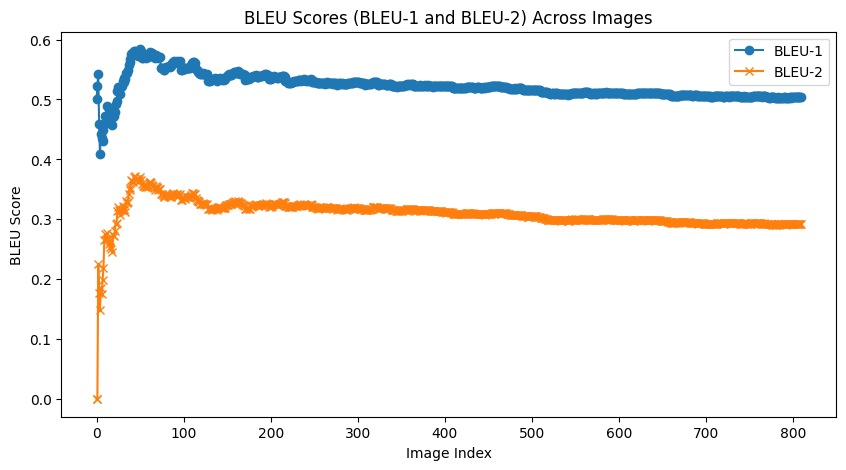

In [ ]:

# Plotting BLEU Scores

# 1. Line plot of BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(bleu_1_scores, label="BLEU-1", marker='o')
plt.plot(bleu_2_scores, label="BLEU-2", marker='x')
plt.xlabel("Image Index")
plt.ylabel("BLEU Score")
plt.title("BLEU Scores (BLEU-1 and BLEU-2) Across Images")
plt.legend()
plt.show()


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU-1: 0.333333
BLEU-2: 0.000000
BLEU-1: 0.392857
BLEU-2: 0.212908
BLEU-1: 0.405405
BLEU-2: 0.218391
BLEU-1: 0.380000
BLEU-2: 0.181779
BLEU-1: 0.360656
BLEU-2: 0.160503
BLEU-1: 0.393939
BLEU-2: 0.181186
BLEU-1: 0.303922
BLEU-2: 0.138546
BLEU-1: 0.333333
BLEU-2: 0.170664
BLEU-1: 0.330645
BLEU-2: 0.160862
BLEU-1: 0.350365
BLEU-2: 0.174203
BLEU-1: 0.369863
BLEU-2: 0.188723
BLEU-1: 0.381818
BLEU-2: 0.193476
BLEU-1: 0.396552
BLEU-2: 0.216329
BLEU-1: 0.392473
BLEU-2: 0.208218
BLEU-1: 0.373206
BLEU-2: 0.191183
BLEU-1: 0.366071
BLEU-2: 0.182864
BLEU-1: 0.381974
BLEU-2: 0.188064
BLEU-1: 0.387500
BLEU-2: 0.186842
BLEU-1: 0.395257
BLEU-2: 0.197104
BLEU-1: 0.404494
BLEU-2: 0.214135
BLEU-1: 0.407942
BLEU-2: 0.214970
BLEU-1: 0.418118
BLEU-2: 0.224699
BLEU-1: 0.425676
BLEU-2: 0.226838
BLEU-1: 0.430921
BLEU-2: 0.228749
BLEU-1: 0.440895
BLEU-2: 0.244345
BLEU-1: 0.453125
BLEU-2: 0.254425
BLEU-1: 0.449541
BLEU-2: 0.250870
BLEU-1: 0.452663
BLEU-2: 0.256338
BLEU-1: 0.459538
BLEU-2: 0.258232
BLEU-1: 0.4720


Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy bites hard into treat while he sits outside endseq
startseq child biting into baked good endseq
startseq small boy putting something in his mouth with both hands endseq
startseq the boy eats his food outside at the table endseq
startseq the boy is eating pizza over tin dish endseq
--------------------Predicted--------------------
startseq the boy is eating of something endseq


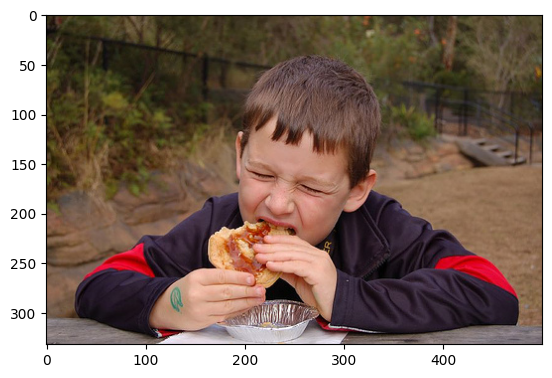

In [ ]:
generate_caption("1034276567_49bb87c51c.jpg")

---------------------Actual---------------------
startseq grey dog beside black and white dog running in green grass endseq
startseq two dogs are wrestling in grassy field endseq
startseq "two dogs playing in field wrestling with each other" endseq
startseq two dogs run along grassy field while one bites the other endseq
startseq two dogs wrestle in field endseq
--------------------Predicted--------------------
startseq two dogs are running in field endseq


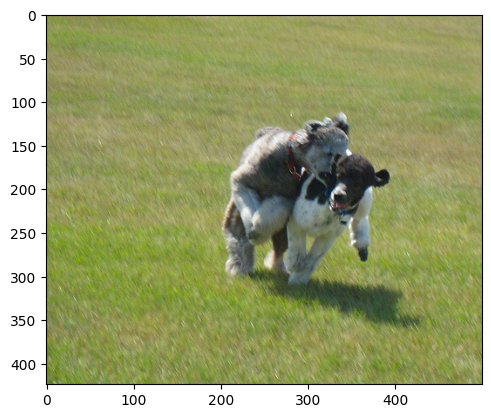

In [ ]:
generate_caption("1164131282_b30926f332.jpg")

---------------------Actual---------------------
startseq brown dog plays in deep pile of snow endseq
startseq dog looking at the camera in snow endseq
startseq dog runs through the snow endseq
startseq tan dog stand in the snow and looks up endseq
startseq the brown dog is out in the snow endseq
--------------------Predicted--------------------
startseq tan dog is running through the snow endseq


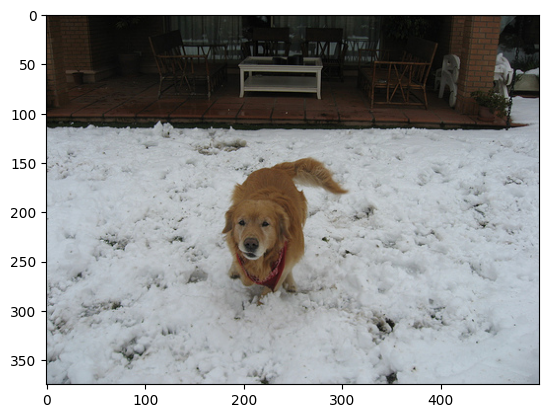

In [ ]:
generate_caption("1094462889_f9966dafa6.jpg")

In [ ]:
boy bites hard into treat while he sits outside
child biting into baked good
small boy putting something in his mouth with both hands
the boy eats his food outside at the table
the boy is eating pizza over tin dish

---------------------Actual---------------------
startseq hiker standing high on bluff overlooking the mountains below endseq
startseq person on ski 's looks from hill over snow covered landscape endseq
startseq skier is overlooking snow-covered mountain endseq
startseq skier is overlooking the beautiful white snow covered landscape endseq
startseq skier pauses on mountaintop endseq
--------------------Predicted--------------------
startseq two people are walking on snow covered covered hill endseq


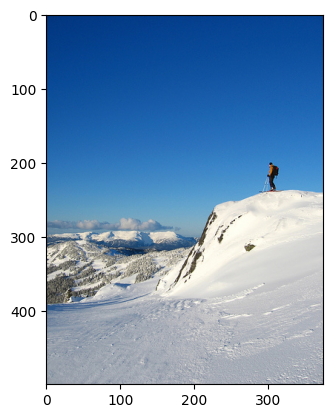

In [ ]:
generate_caption("106514190_bae200f463.jpg")

---------------------Actual---------------------
startseq boy hanging onto pole endseq
startseq kid in green shirt playing in the park endseq
startseq little kid swings on pole at playground endseq
startseq the boy in the green shirt swings with one arm on the silver pole endseq
startseq the boy is swinging on pole at the beach endseq
--------------------Predicted--------------------
startseq boy wearing red shirt and jeans is standing on bench endseq


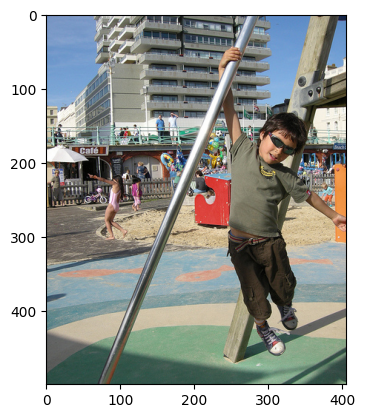

In [ ]:
generate_caption("3759492488_592cd78ed1.jpg")

---------------------Actual---------------------
startseq man in glasses and an asian woman are seated across from each other in subway train endseq
startseq people on subway endseq
startseq people sit inside train endseq
startseq several people sit on train endseq
startseq two men and one woman are sitting in subway train endseq
--------------------Predicted--------------------
startseq two women are sitting on bench endseq


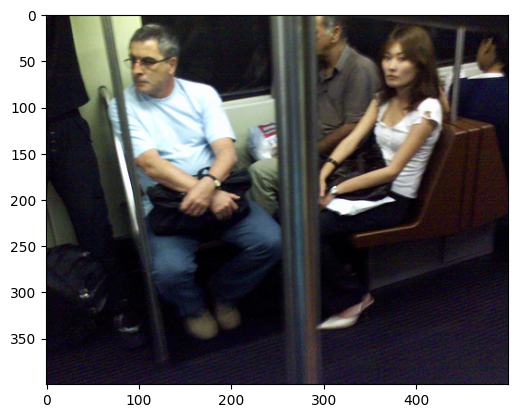

In [ ]:
generate_caption("1332208215_fa824f6659.jpg")

---------------------Actual---------------------
startseq girl is reading while drinking starbuck 's coffee endseq
startseq seated young woman in hat is reading at coffee shop endseq
startseq woman enjoying her reading at coffee shop endseq
startseq woman in hat sits reading and drinking coffee endseq
startseq young woman sips coffee and reads book endseq
--------------------Predicted--------------------
startseq man in white shirt and headphones sitting on bench endseq


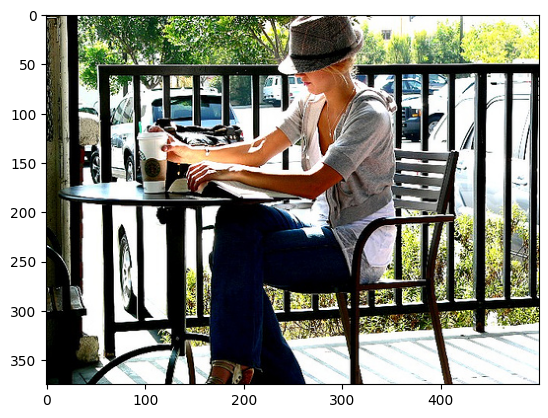

In [ ]:
generate_caption("1547883892_e29b3db42e.jpg")

---------------------Actual---------------------
startseq boy hanging onto pole endseq
startseq kid in green shirt playing in the park endseq
startseq little kid swings on pole at playground endseq
startseq the boy in the green shirt swings with one arm on the silver pole endseq
startseq the boy is swinging on pole at the beach endseq
--------------------Predicted--------------------
startseq boy wearing red shirt and jeans is standing on bench endseq


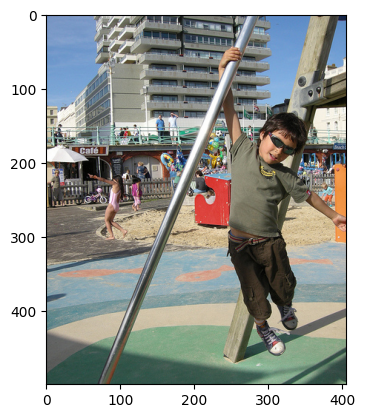

In [ ]:
generate_caption("3759492488_592cd78ed1.jpg")

In [ ]:
image_ids[7899]

'758921886_55a351dd67'

---------------------Actual---------------------
startseq girl wearing blue dress is sliding down tube slide endseq
startseq little girl in white top is inside concrete tube endseq
startseq little girl is sliding down tunnel smiling endseq
startseq little girl smiles as she slides down tube on sunny day endseq
startseq young girl in inside tunnel endseq
--------------------Predicted--------------------
startseq little girl in pink shirt and pink shirt is standing on bench endseq


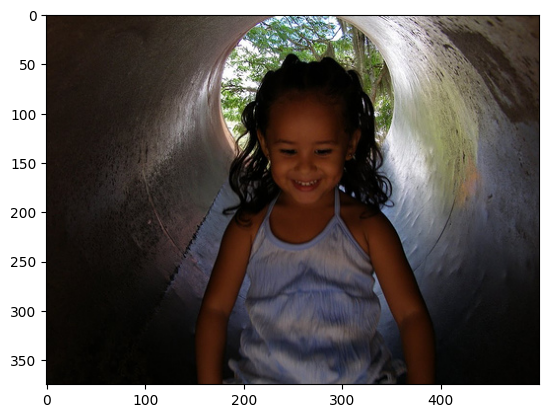

In [ ]:
generate_caption("758921886_55a351dd67.jpg")

---------------------Actual---------------------
startseq man in pets dog on the chest at park endseq
startseq man petting dog endseq
startseq young man scratches the neck of dog endseq
startseq young man sits with dog outside endseq
startseq young man sitting and petting his dog endseq
--------------------Predicted--------------------
startseq the brown dog is running through grass endseq


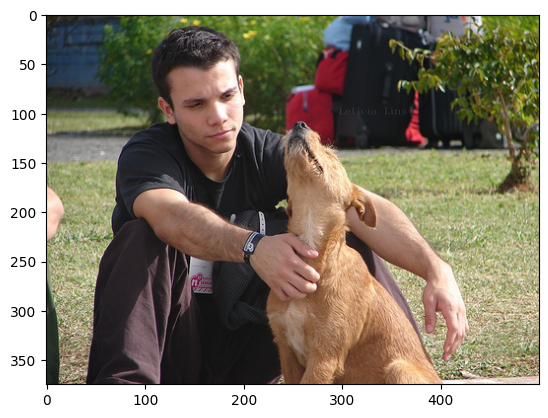

In [ ]:
generate_caption("930748509_8ca5cf5c24.jpg")